In [1]:
import quantum_kan 
import symengine as se
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.metrics import mean_squared_error, r2_score
from pyqubo import Binary, Array
import os
from dwave.embedding.chain_breaks import majority_vote
from dimod import BinaryQuadraticModel
import dwave.inspector
# Solve the QUBO using a quantum annealer
from dwave.samplers import SimulatedAnnealingSampler
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridSampler, FixedEmbeddingComposite
from dwave.embedding.chain_strength import uniform_torque_compensation
import time 
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from qkan import KAN
import torch.nn as nn
import minorminer
import networkx as nx

# Set your D-Wave API token
import os
env_vars = !cat dwave.env
for var in env_vars:
    key, value = var.split('=')
    os.environ[str(key)] = str(value)
#Advantage_system6.4 or Advantage2_prototype2.3
sampler = EmbeddingComposite(DWaveSampler(solver='Advantage2_prototype2.3'))
hybrid_sampler = LeapHybridSampler(solver="hybrid_binary_quadratic_model_version2")

simulated_sampler = SimulatedAnnealingSampler()

# Set the number of threads for intra-op parallelism (used for CPU operations)
torch.set_num_threads(1)

# Set the number of threads for inter-op parallelism (used for parallelism between operations)
torch.set_num_interop_threads(1)

# Verify the settings
print(f"Number of intra-op threads: {torch.get_num_threads()}")
print(f"Number of inter-op threads: {torch.get_num_interop_threads()}")


Number of intra-op threads: 1
Number of inter-op threads: 1


In [2]:
def convert_sympy_to_pyqubo(objective_func, conversion_dict):
    # Parse the simplified symbolic equation and update the QUBO matrix
    
    expression = mse_with_penalty_str
    pyqubo_expr = 0
    # Replace '-' with '+-' to simplify splitting
    expression = expression.replace(' - ', ' + -')
    # Split the expression into terms
    terms = expression.split(' + ')
    pyqubo_obj = 0

    for term in terms:
        # Split term into coefficient and variable parts
        parts = term.split('*')
        current_pyqubo_term = int(0)
        first_var = True
        for part in parts:
            if ('P' in part) or ('AUX' in part):
                current_pyqubo_var = conversion_dict.get(part)
            else:
                current_pyqubo_var = float(part)
                
            if first_var:
                current_pyqubo_term = current_pyqubo_var
                first_var = False
            else:
                current_pyqubo_term = current_pyqubo_term * current_pyqubo_var
        # current_pyqubo_term = current_pyqubo_term * coeff
        pyqubo_obj += current_pyqubo_term
        del current_pyqubo_term
        
    return pyqubo_obj

# Define the Bernstein polynomial basis functions
def bernstein_basis_functions(x, degree):
    """
    Calculates the Bernstein polynomial basis functions.

    Args:
        x (array-like): Points at which to evaluate the basis functions.
        degree (int): Degree of the Bernstein polynomial.

    Returns:
        numpy.ndarray: A 2D array of shape (n_basis, len(x)), where each row 
                       represents a basis function evaluated at the points in x.
    """
    n = degree
    basis = np.zeros((n+1, len(x)))

    for i in range(n+1):
        binomial_coeff = math.comb(n, i)
        basis[i, :] = binomial_coeff * (x**i) * ((1 - x)**(n - i))

    return basis

def bernstein_poly(i, n, t):
    """Compute the Bernstein polynomial B_i^n at t."""
    return comb(n, i) * (t ** i) * ((1 - t) ** (n - i))

def bezier_curve(coefficients, t):
    """Compute a Bezier curve given coefficients and parameter t."""
    n = len(coefficients) - 1
    return sum(coefficients[i] * bernstein_poly(i, n, t) for i in range(n + 1))

# Normalize x_data and y_data
def normalize(data):
    data_min, data_max = data.min(), data.max()
    return (data - data_min) / (data_max - data_min)


# Define a custom base function that always returns zero
class ZeroBaseFunction(nn.Module):
    def forward(self, x):
        return torch.zeros_like(x)
    
def separate_vars(solution):
    """
    Separate coefficients and auxiliary variables from the solution dictionary.

    :param solution: The solution dictionary containing both coefficients and auxiliary variables.
    :return: Two dictionaries, one for coefficients and one for auxiliary variables.
    """
    aux_vars = {k: v for k, v in solution.items() if k.startswith('aux')}
    coeff_vars = {k: v for k, v in solution.items() if k.startswith('coeff')}
    
    return aux_vars, coeff_vars

def create_reverse_lookup_dict(original_dict):
    """
    Create a reverse lookup dictionary from the given dictionary.

    :param original_dict: The original dictionary to reverse.
    :return: A new dictionary where keys are the original values and values are the original keys.
    """
    reverse_dict = {v: k for k, v in original_dict.items()}
    return reverse_dict

def map_solution_variables(solution, reverse_dict):
    """
    Map solution variables from PyQUBO to SymPy using the reverse dictionary.

    :param solution: The solution dictionary with PyQUBO variables.
    :param reverse_dict: The reverse lookup dictionary to map PyQUBO variables to SymPy variables.
    :return: A new dictionary with SymPy variables as keys and solution values.
    """
    mapped_solution = {}
    for pyqubo_var, value in solution.items():
        sympy_var = reverse_dict.get(Binary(pyqubo_var))
        if sympy_var is not None:
            mapped_solution[sympy_var] = value
        else:
            print(f"Warning: PyQUBO variable {pyqubo_var} not found in reverse mapping.")
    return mapped_solution

def separate_aux_and_binary_vars(mapped_solution, include_aux_in_binary=False):
    """
    Separate coefficients and auxiliary variables from the mapped solution dictionary.

    :param mapped_solution: The mapped solution dictionary containing both coefficients and auxiliary variables.
    :return: Two dictionaries, one for coefficients and one for auxiliary variables.
    """
    aux_vars = {str(k).replace('"','').replace("'",""): v for k, v in mapped_solution.items() if str(k).replace('"','').replace("'","").startswith('AUX')}
    if include_aux_in_binary == True:
        binary_vars = {str(k).replace('"','').replace("'",""): v for k, v in mapped_solution.items() if  str(k).replace('"','').replace("'","")}
    else:
        binary_vars = {str(k).replace('"','').replace("'",""): v for k, v in mapped_solution.items() if not str(k).replace('"','').replace("'","").startswith('AUX')}
    
    return aux_vars, binary_vars

def check_aux_variables(binary_vars, aux_vars, aux_dict_all):
    """
    Check if auxiliary variables correctly represent the product of their respective binary variables.

    :param binary_vars: Dictionary of binary variable values (e.g., {'x1': 0, 'x2': 1, ...})
    :param aux_vars: Dictionary of auxiliary variable values (e.g., {'z1': 1, 'z2': 0, ...})
    :param aux_dict_all: Dictionary mapping auxiliary variables to their respective binary variable products
                         (e.g., {'z1': x1*x2, 'z2': x2*x3, ...})
    :return: Dictionary indicating whether each auxiliary variable is correct (e.g., {'z1': True, 'z2': False, ...})
    """
    results = {}

    for aux_var, aux_expr in aux_dict_all.items():
        # Extract the binary variables involved in the product
        vars_in_expr = aux_expr.split('*')
        product_value = 1
        aux_var = str(aux_var)

        # Calculate the expected value by multiplying the values of the binary variables
        for var in vars_in_expr:
            var = str(var)
            if var in binary_vars:
                product_value *= binary_vars[var]
            else:
                raise ValueError(f"Variable {var} not found in binary_vars dictionary")

        # Check if the auxiliary variable's value matches the expected product value
        if aux_var in aux_vars:
            results[aux_var] = (aux_vars[aux_var] == product_value)
        else:
            raise ValueError(f"Auxiliary variable {aux_var} not found in aux_vars dictionary")

    return results
    
def create_dataset(f, 
                   n_var=2, 
                   ranges = [0,1],
                   train_num=1000, 
                   test_num=1000,
                   normalize_input=True,
                   normalize_label=False,
                   device='cpu',
                   seed=0):
    '''
    create dataset
    
    Args:
    -----
        f : function
            the symbolic formula used to create the synthetic dataset
        ranges : list or np.array; shape (2,) or (n_var, 2)
            the range of input variables. Default: [0,1].
        train_num : int
            the number of training samples. Default: 1000.
        test_num : int
            the number of test samples. Default: 1000.
        normalize_input : bool
            If True, apply normalization to inputs. Default: False.
        normalize_label : bool
            If True, apply normalization to labels. Default: False.
        device : str
            device. Default: 'cpu'.
        seed : int
            random seed. Default: 0.
        
    Returns:
    --------
        dataset : dic
            Train/test inputs/labels are dataset['train_input'], dataset['train_label'],
                        dataset['test_input'], dataset['test_label']
         
    Example
    -------
    >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
    >>> dataset = create_dataset(f, n_var=2, train_num=100)
    >>> dataset['train_input'].shape
    torch.Size([100, 2])
    '''

    np.random.seed(seed)
    torch.manual_seed(seed)

    if len(np.array(ranges).shape) == 1:
        ranges = np.array(ranges * n_var).reshape(n_var, 2)
    else:
        ranges = np.array(ranges)
        
    train_input = torch.zeros(train_num, n_var)
    test_input = torch.zeros(test_num, n_var)
    for i in range(n_var):
        train_input[:, i] = torch.rand(train_num) * (ranges[i, 1] - ranges[i, 0]) + ranges[i, 0]
        test_input[:, i] = torch.rand(test_num) * (ranges[i, 1] - ranges[i, 0]) + ranges[i, 0]
        
    train_label = f(train_input)
    test_label = f(test_input)
        
    if normalize_label == True:
        mean_label = torch.mean(train_label, dim=0, keepdim=True)
        std_label = torch.std(train_label, dim=0, keepdim=True)
        train_label = (train_label - mean_label) / std_label
        test_label = (test_label - mean_label) / std_label

    dataset = {}
    dataset['train_input'] = train_input.to(device)
    dataset['test_input'] = test_input.to(device)
    dataset['train_label'] = train_label.to(device)
    dataset['test_label'] = test_label.to(device)

    return dataset

def split_dataset(dataset, splits):
    """
    Split dataset into multiple smaller datasets.
    
    Args:
    -----
        dataset : dict
            The dataset containing 'train_input' and 'train_label'.
        splits : list
            List of integers specifying the size of each split.
            
    Returns:
    --------
        split_datasets : list
            List of datasets, each containing 'train_input' and 'train_label'.
    """
    total_size = sum(splits)
    assert total_size == len(dataset['train_input']), "Sum of splits must equal the total dataset size."
    
    # Create a list of indices and shuffle them
    indices = torch.randperm(total_size)
    
    split_datasets = []
    start_idx = 0
    
    for split_size in splits:
        end_idx = start_idx + split_size
        split_indices = indices[start_idx:end_idx]
        
        split_input = dataset['train_input'][split_indices]
        split_label = dataset['train_label'][split_indices]
        
        split_dataset = {
            'train_input': split_input,
            'train_label': split_label,
            'test_input': torch.empty(0, split_input.shape[1]),  # Empty tensor with the same number of columns as train_input
            'test_label': torch.empty(0, split_label.shape[1])   # Empty tensor with the same number of columns as train_label
        }
        
        split_datasets.append(split_dataset)
        start_idx = end_idx
        
    return split_datasets



In [3]:
def train_classical_optimizer(dataset, degrees, optimizer, steps, learning_rates, T, U, Z_ideal, Z_ideal_flat):
    best_lr = None
    best_mse = 100000
    grid_points = np.c_[T.ravel(), U.ravel()]
    grid_points_tensor = torch.from_numpy(grid_points).float()

    for lr in learning_rates:
        model = KAN(width=[2, 1, 1], degrees=degrees, bias_trainable=False, base_fun=ZeroBaseFunction()).float()
        start = time.perf_counter()
        results = model.train(dataset, opt=optimizer, steps=steps, log=10, lr=lr)
        end = time.perf_counter()
        training_time = end - start
        print(f"Training time in seconds of lr={lr}: {training_time}")  # will print the elapsed time in seconds

        # Compute the model predictions
        with torch.no_grad():
            Z_model = model(grid_points_tensor).numpy().reshape(T.shape)
            
        # Flatten the arrays for comparison
        Z_model_flat = Z_model.ravel()

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(Z_ideal_flat, Z_model_flat)
        r2 = r2_score(Z_ideal_flat, Z_model_flat)
        if mse < best_mse:
            best_mse = mse
            best_lr = lr
        print(f"Learning Rate: {lr}, Train MSE: {mse}, Train r2: {r2}")

    print(f"Best Learning Rate: {best_lr} with Train MSE: {best_mse}")

    # Plot the results using the best learning rate
    model = KAN(width=[2, 1, 1], degrees=degrees, bias_trainable=False, base_fun=ZeroBaseFunction()).float()


    start = time.perf_counter()

    results = model.train(dataset, opt=optimizer, steps=steps, log=10, lr=best_lr)
    end = time.perf_counter()
    time_best_lr = end - start

    print(f"Training time in seconds: {time_best_lr}")  # will print the elapsed time in seconds

    # Print final Bezier coefficients for each layer
    for layer_idx, layer in enumerate(model.act_fun):
        print(f"Layer {layer_idx} Bezier coefficients:")
        print(layer.coef.data.cpu().numpy())

    # Compute the model predictions
    with torch.no_grad():
        Z_model = model(grid_points_tensor).numpy().reshape(T.shape)

    # Plot the ideal function
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.contourf(T, U, Z_ideal, levels=100, cmap='viridis')
    plt.colorbar()
    plt.title('Ideal Function')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Plot the model predictions
    plt.subplot(1, 2, 2)
    plt.contourf(T, U, Z_model, levels=100, cmap='viridis')
    plt.colorbar()
    plt.title('Model Predictions')
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.tight_layout()
    plt.show()

    # Calculate metrics
    # Flatten the arrays for comparison
    Z_model_flat = Z_model.ravel()

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(Z_ideal_flat, Z_model_flat)

    # Calculate R-squared (R²)
    r2 = r2_score(Z_ideal_flat, Z_model_flat)

    print(f"Training time: {time_best_lr}, mse: {mse}, r2: {r2}")

    return time_best_lr, mse, r2

In [4]:
def run_annealing(type, sampler, problem, chain_strength, time_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=1000, annealing_time=20):
    #Check if quantum annealer, hybrid quantum annealer, or simulated annealer
    if type == "QA":
        response = sampler.sample(problem, num_reads=num_reads, chain_strength=chain_strength, annealing_time=annealing_time)
        # Extract and print timing information
        timing_info = response.info['timing']

        print("Timing Information:")
        for key, value in timing_info.items():
            print(f"{key}: {value} microseconds")

        # Specific time spent on the quantum processor
        qpu_access_time = timing_info.get('qpu_access_time', 'N/A')
        print(f"\nQPU Access Time: {qpu_access_time} microseconds")

        time_part2 = qpu_access_time * (10**(-6))
        print(f"Time spent on quantum annealer part 2: {time_part2}")  # will print the elapsed time in seconds

    elif type == "HQA":
        response = sampler.sample(problem)
        # Extract and print timing information
        timing_info = response.info

        # Print timing information
        print("Timing Information:")
        for key, value in timing_info.items():
            print(f"{key}: {value} microseconds")

        # Specific time spent on the quantum processor
        qpu_access_time = timing_info.get('qpu_access_time', 'N/A')
        print(f"\nQPU Access Time: {qpu_access_time} microseconds")

        dwave_run_time = timing_info.get('run_time', 'N/A')
        print(f"\nTotal D-Wave Run Time Including Setup: {dwave_run_time} microseconds")

        time_part2 = dwave_run_time * (10**(-6))
        print(f"Time spent on hybrid part 2: {time_part2}")  # will print the elapsed time in seconds

    elif type == "SA":
        # Simulated annealing doesnt converge to a good solution as fast so generally takes more reads
        start_time_part2 = time.perf_counter()
        response = sampler.sample_qubo(problem, num_reads=num_reads)
        end_time_part2 = time.perf_counter()
        time_part2 = end_time_part2 - start_time_part2
        print(f"Time spent on simulated part 2: {time_part2}")  # will print the elapsed time in seconds
    
    # Start part 3
    start_time_part3 = time.perf_counter()
    solution = response.first.sample
    # Extract optimized coefficients
    optimized_coefficients_1 = []
    for i in range(num_basis_funcs_1):
        coeff_value_1 = sum(2**j * solution[f'coeff_plus_1[{i}][{j + m1 - 1}]'] for j in range(-m1 + 1, 1))
        optimized_coefficients_1.append(coeff_value_1)
        
    optimized_coefficients_2 = []
    for i in range(num_basis_funcs_2):
        coeff_value_2 = sum(2**j * solution[f'coeff_plus_2[{i}][{j + m2 - 1}]'] for j in range(-m2 + 1, 1))
        optimized_coefficients_2.append(coeff_value_2)
        
    optimized_coefficients_3 = []
    for i in range(num_basis_funcs_3):
        coeff_value_3 = sum(2**j * solution[f'coeff_plus_3[{i}][{j + m3 - 1}]'] for j in range(-m3 + 1, 1))
        optimized_coefficients_3.append(coeff_value_3)
        
    optimized_aux = []
    for i in range(num_aux):
        coeff_value_1 = solution[f'aux[{i}]']
        optimized_aux.append(coeff_value_1)
    end_time_part3 = time.perf_counter()

    time_part3 = end_time_part3 - start_time_part3
    print(f"Time spent on part 3: {time_part3}")  # will print the elapsed time in seconds

    total_time_optimization = time_part1 + time_part2 + time_part3
    print(f"Time spent on optimization: {total_time_optimization}")  # will print the elapsed time in seconds
    print(f"optimized_coefficients_1: {optimized_coefficients_1}")
    print(f"optimized_coefficients_2: {optimized_coefficients_2}")
    print(f"optimized_coefficients_3: {optimized_coefficients_3}")

    # Separate coefficients and auxiliary variables
    aux_vars, coeff_vars = separate_vars(solution)
    # Create reverse lookup dictionary
    reverse_dict = create_reverse_lookup_dict(sympy_to_pyqubo_map)
    # Map solution variables from PyQUBO to SymPy
    mapped_solution = map_solution_variables(solution, reverse_dict)
    include_aux_in_binary = True
    aux_vars, binary_vars = separate_aux_and_binary_vars(mapped_solution, include_aux_in_binary)
    # Check the auxiliary variable values
    results_aux_check = check_aux_variables(binary_vars, aux_vars, aux_dict_str)

    # Print the results
    for aux_var, is_correct in results_aux_check.items():
        print(f"{aux_var}: {'Correct' if is_correct else 'Incorrect'}")

    # Compute Bézier curve values for each grid point
    B1_values = np.array([[bezier_curve(optimized_coefficients_1, t) + bias_coefficient * t**2 for t in t_row] for t_row in T])
    B2_values = np.array([[bezier_curve(optimized_coefficients_2, u) + bias_coefficient * u**2 for u in u_row] for u_row in U])


    # Compute Bézier3 using the output of Bézier1 and Bézier2
    Z_model = np.array([[bezier_curve(optimized_coefficients_3, (B1_values[i, j] + B2_values[i, j])) + bias_coefficient * (B1_values[i, j] + B2_values[i, j])**2 for j in range(len(T))] for i in range(len(U))])

    # Plotting the 3D surface plots side by side
    fig = plt.figure(figsize=(20, 8))

    plt.subplot(1, 2, 1)
    plt.contourf(T, U, Z_ideal, levels=100, cmap='viridis')
    plt.colorbar()
    plt.title('Ideal Function')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Plot the model predictions
    plt.subplot(1, 2, 2)
    plt.contourf(T, U, Z_model, levels=100, cmap='viridis')
    plt.colorbar()
    plt.title('Quantum Annealing Model Predictions')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Calculate metrics
    # Flatten the arrays for comparison
    Z_model_flat = Z_model.ravel()

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(Z_ideal_flat, Z_model_flat)

    # Calculate R-squared (R²)
    r2 = r2_score(Z_ideal_flat, Z_model_flat)

    print(f"Training time: {total_time_optimization}, MSE: {mse:.4f}, r2: {r2:.4f}")
    print(f"time_part1: {time_part1}, time_part2: {time_part2}, time_part3: {time_part3}")
    return time_part2, time_part3, total_time_optimization, mse, r2

In [5]:
# Define the spherical harmonic function for m=0 and n=1
def spherical_harmonic_m0_n1(x):
    theta = x[:, 0] * np.pi  # Scale to range [0, pi]
    phi = x[:, 1] * 2 * np.pi  # Scale to range [0, 2*pi]
    y = (np.sqrt(3 / (4 * np.pi)) * np.cos(theta) + 0.5)
    return torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [6]:
# Defining variables for the networks
degree1 = 1
degree2 = 1
degree3 = 1
degrees=[degree1,degree3]
m1 = 1
m2 = 2
m3 = 3
function_multiplier = 1
penalty_multiplier = 25
bias_coefficient = 0.0
is_fractional=True

num_basis_funcs_1 = degree1 + 1
num_basis_funcs_2 = degree2 + 1
num_basis_funcs_3 = degree3 + 1

save_file1 = "sph_harm_hybrid_retraining_mse_save1.json"
save_file2 = "sph_harm_hybrid_retraining_mse_save2.json"
save_file3 = "sph_harm_hybrid_retraining_mse_save3.json"
save_file4 = "sph_harm_hybrid_retraining_mse_save4.json"

# Define variables to keep track of time
total_time_quantum = []
total_time_hybrid = []
total_time_simulated = []
total_time_adam = []
total_time_sgd = []
total_time_adagrad = []

In [7]:
dataset_size = 1400000
# Create dataset with normalized inputs between 0 and 1
dataset = create_dataset(spherical_harmonic_m0_n1, n_var=2, train_num=dataset_size, test_num=0, ranges=[0, 1])

# Define the sizes of the splits
splits = [1000000, 100000, 100000, 100000, 100000]

# Split the dataset
split_datasets = split_dataset(dataset, splits)

# Example usage
for i, split_dataset in enumerate(split_datasets):
    print(f"Dataset {i+1}:")
    print(f"  Input shape: {split_dataset['train_input'].shape}")
    print(f"  Label shape: {split_dataset['train_label'].shape}")
    if i == 0:
        dataset = split_dataset
    elif i == 1:
        dataset_split1 = split_dataset
    elif i == 2:
        dataset_split2 = split_dataset
    elif i == 3:
        dataset_split3 = split_dataset
    elif i == 4:
        dataset_split4 = split_dataset
    
X = dataset['train_input']
y = dataset['train_label']
x_data = X[:, 0].numpy()
y_data = X[:, 1].numpy()
z_data = y[:, 0].numpy()

# Make z_ideal
# Define the spherical harmonic function for m=0 and n=1
def spherical_harmonic_m0_n1_scaled(t, u, multiplier):
    theta = t * np.pi  # Scale t to range [0, pi]
    phi = u * 2 * np.pi  # Scale u to range [0, 2*pi]
    return (np.sqrt(3 / (4 * np.pi)) * np.cos(theta) + 0.5) * multiplier

# Generate a grid of t and u values for the 3D plot
t_values = np.linspace(0, 1, 30)
u_values = np.linspace(0, 1, 30)
T, U = np.meshgrid(t_values, u_values)

# Compute the ideal function values
Z_ideal = np.array([[spherical_harmonic_m0_n1_scaled(t, u, function_multiplier) for t, u in zip(t_row, u_row)] for t_row, u_row in zip(T, U)])
Z_ideal_flat = Z_ideal.ravel()

Dataset 1:
  Input shape: torch.Size([1000000, 2])
  Label shape: torch.Size([1000000, 1])
Dataset 2:
  Input shape: torch.Size([100000, 2])
  Label shape: torch.Size([100000, 1])
Dataset 3:
  Input shape: torch.Size([100000, 2])
  Label shape: torch.Size([100000, 1])
Dataset 4:
  Input shape: torch.Size([100000, 2])
  Label shape: torch.Size([100000, 1])
Dataset 5:
  Input shape: torch.Size([100000, 2])
  Label shape: torch.Size([100000, 1])


/tmp/ipykernel_26355/1510031437.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(y, dtype=torch.float32).reshape(-1, 1)


# Run Quantum Annealing

In [8]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist(),
    save_filename=save_file1
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
# Mapping for P variables
for var in sorted(Solving_for_vars):
    var = str(var)
    if '_' in var:
        parts = var.split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]

# Mapping for AUX variables
aux_var_to_index = {var: idx for idx, var in enumerate(aux_dict_str.keys())}
for aux_var in aux_dict_str.keys():
    sympy_to_pyqubo_map[f"{aux_var}"] = coefficients_aux[aux_var_to_index[aux_var]]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm) #* 2.0

end_time_quantum_part1 = time.perf_counter()
    

In [9]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 0.4943365180006367


Timing Information:
qpu_sampling_time: 324420.0 microseconds
qpu_anneal_time_per_sample: 20.0 microseconds
qpu_readout_time_per_sample: 67.57 microseconds
qpu_access_time: 343646.82 microseconds
qpu_access_overhead_time: 1838.18 microseconds
qpu_programming_time: 19226.82 microseconds
qpu_delay_time_per_sample: 20.57 microseconds
post_processing_overhead_time: 1.0 microseconds
total_post_processing_time: 1.0 microseconds

QPU Access Time: 343646.82 microseconds
Time spent on quantum annealer part 2: 0.34364681999999996
Time spent on part 3: 0.0009181300001728232
Time spent on optimization: 0.8389014680008096
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Co

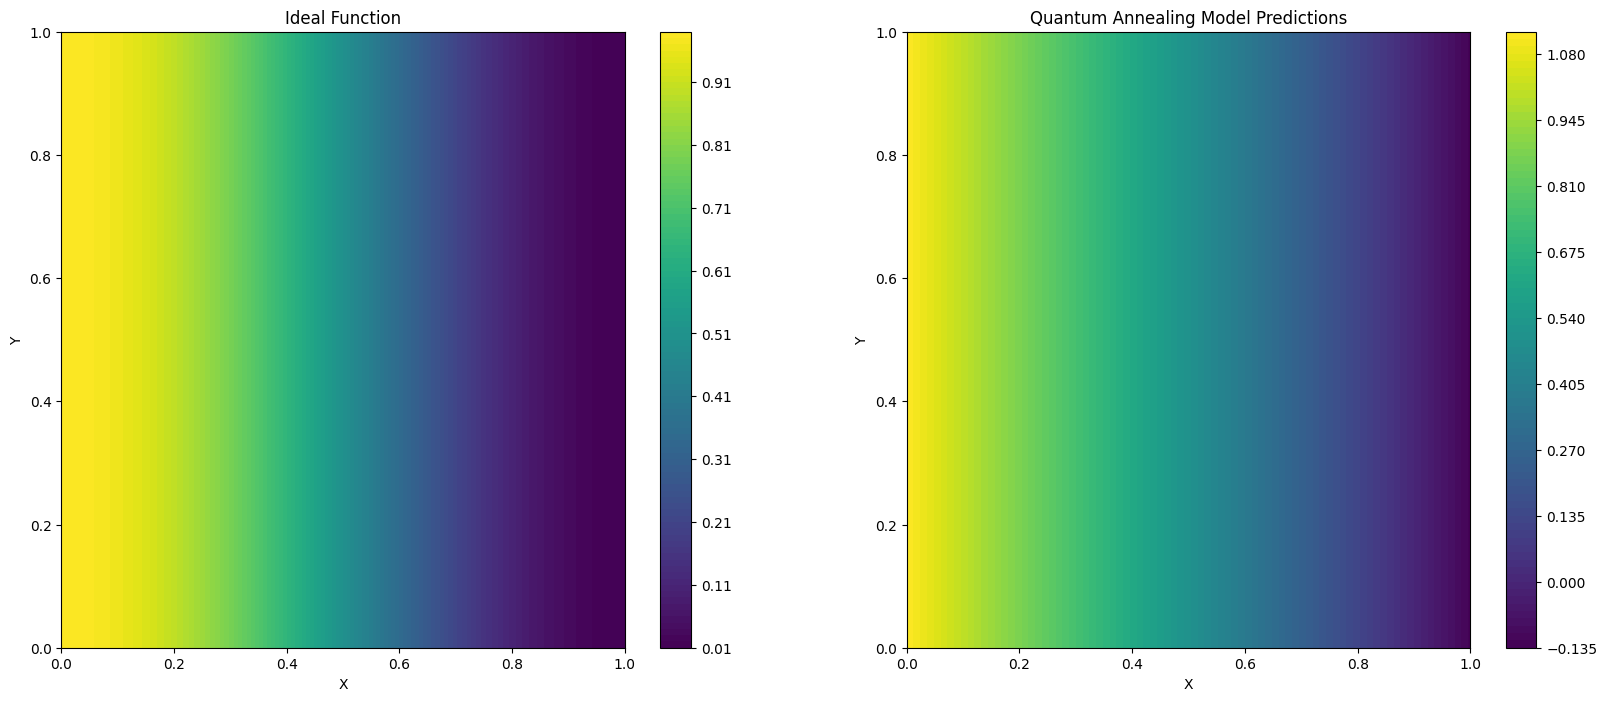

In [10]:
quantum_time_part2, quantum_time_part3, quantum_total_time_optimization, quantum_mse, quantum_r2 = run_annealing("QA", sampler, bqm, chain_strength * 0.5, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=3000, annealing_time=20)

Timing Information:
qpu_access_time: 130982 microseconds
charge_time: 2999125 microseconds
run_time: 2999125 microseconds
problem_id: 8ee4838b-45b8-4977-b925-2c02c5a58d80 microseconds

QPU Access Time: 130982 microseconds

Total D-Wave Run Time Including Setup: 2999125 microseconds
Time spent on hybrid part 2: 2.999125
Time spent on part 3: 0.0005968110008325311
Time spent on optimization: 3.494058329001469
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX2: Correct
AUX27: Correct
AUX36: Correct
AUX1: Correct
AUX7: Correct
AUX40: Correct
AUX3: Correct
AUX29: Correct
AUX41: C

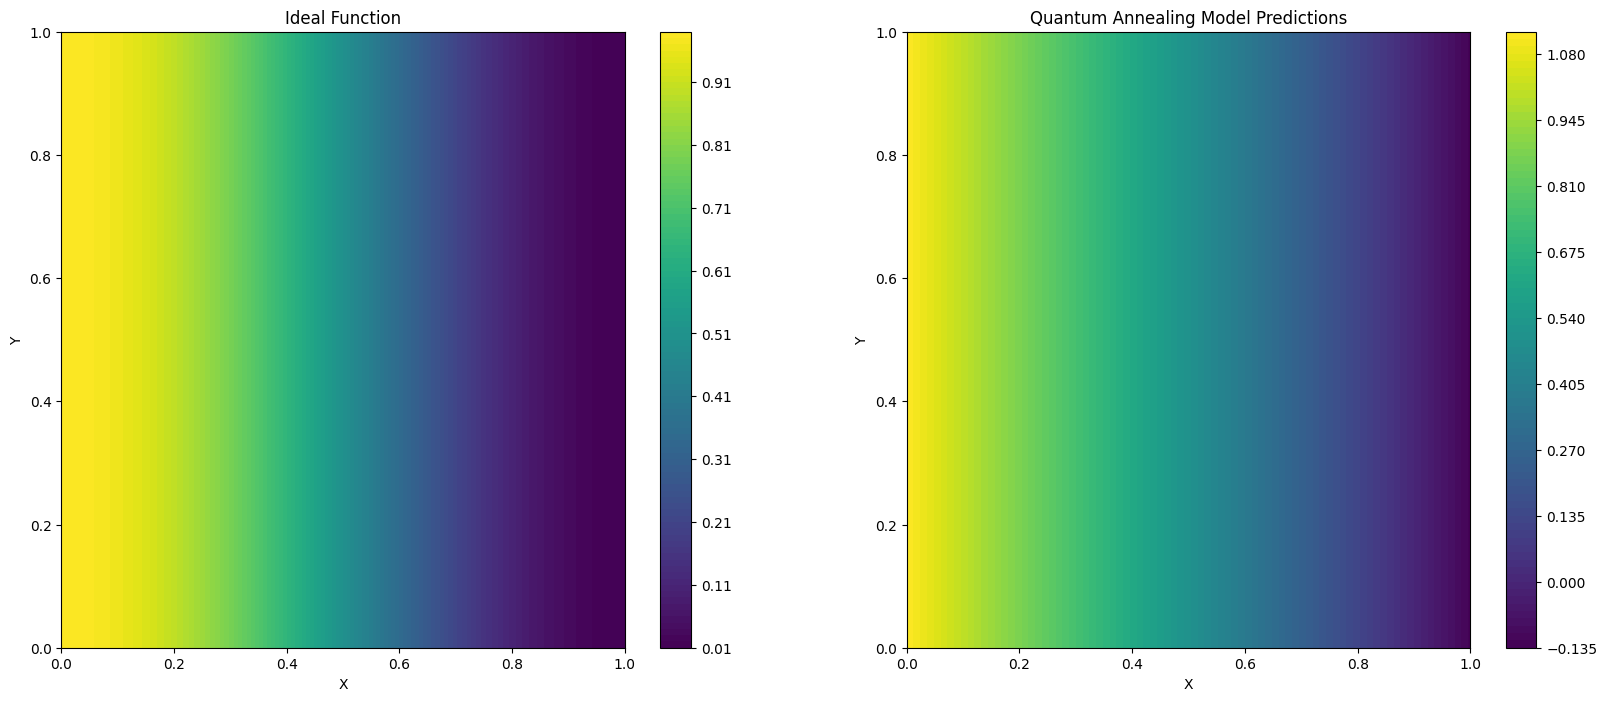

In [11]:
hybrid_time_part2, hybrid_time_part3, hybrid_total_time_optimization, hybrid_mse, hybrid_r2 = run_annealing("HQA", hybrid_sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=2000)

Time spent on simulated part 2: 9.948502115000338
Time spent on part 3: 0.0013585239994426956
Time spent on optimization: 10.444197157000417
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX2: Correct
AUX27: Correct
AUX36: Correct
AUX1: Correct
AUX7: Correct
AUX40: Correct
AUX3: Correct
AUX29: Correct
AUX41: Correct
AUX30: Correct
AUX34: Correct
AUX23: Correct
AUX4: Correct
AUX31: Correct
AUX32: Correct
AUX35: Correct
AUX13: Correct
Training time: 10.444197157000417, MSE: 0.0027, r2: 0.9784
time_part1: 0.4943365180006367, time_part2: 9.948502115000338, time_part3: 0.00135852

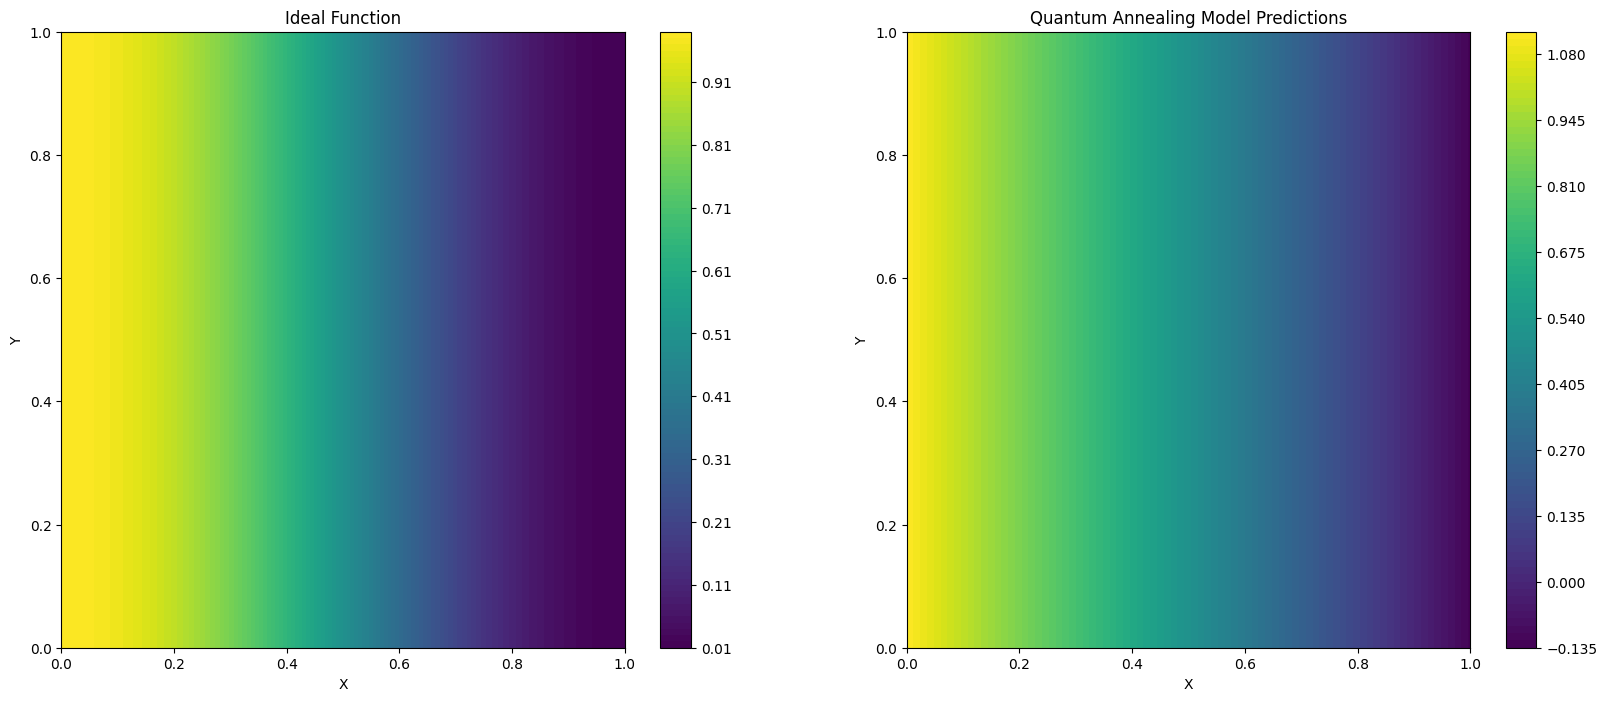

In [12]:
simulated_time_part2, simulated_time_part3, simulated_total_time_optimization, simulated_mse, simulated_r2 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=10000)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.69e-01 | test loss: nan | reg: 3.42e+00 : 100%|███████| 50/50 [00:28<00:00,  1.73it/s]


Training time in seconds of lr=0.001: 28.825115009999536
Learning Rate: 0.001, Train MSE: 0.31424960674179186, Train r2: -1.5477271120864384


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 2.80e-01 | test loss: nan | reg: 3.37e+00 : 100%|███████| 50/50 [00:27<00:00,  1.83it/s]


Training time in seconds of lr=0.01: 27.298187031999987
Learning Rate: 0.01, Train MSE: 0.05422045387051516, Train r2: 0.5604165688931233


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.52e-02 | test loss: nan | reg: 1.63e+00 : 100%|███████| 50/50 [00:26<00:00,  1.86it/s]


Training time in seconds of lr=0.05: 26.912752006999654
Learning Rate: 0.05, Train MSE: 0.0021485942675496302, Train r2: 0.9825806246026347


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.55e-02 | test loss: nan | reg: 1.30e+00 : 100%|███████| 50/50 [00:27<00:00,  1.84it/s]


Training time in seconds of lr=0.1: 27.251774743999704
Learning Rate: 0.1, Train MSE: 0.002468968731061566, Train r2: 0.9799832412194944


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.35e-02 | test loss: nan | reg: 1.16e+00 : 100%|███████| 50/50 [00:27<00:00,  1.82it/s]


Training time in seconds of lr=0.2: 27.534938724000313
Learning Rate: 0.2, Train MSE: 0.0026037694336449573, Train r2: 0.9788903666467595


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.15e-02 | test loss: nan | reg: 2.63e+00 : 100%|███████| 50/50 [00:27<00:00,  1.81it/s]


Training time in seconds of lr=0.5: 27.66378933299984
Learning Rate: 0.5, Train MSE: 0.0035595869763799795, Train r2: 0.971141232787589
Best Learning Rate: 0.05 with Train MSE: 0.0021485942675496302


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.54e-02 | test loss: nan | reg: 1.63e+00 : 100%|███████| 50/50 [00:27<00:00,  1.83it/s]


Training time in seconds: 27.352439688999766
Layer 0 Bezier coefficients:
[[-0.9521379   0.5617988 ]
 [ 0.09327403  0.09469903]]
Layer 1 Bezier coefficients:
[[ 0.37692103 -0.15876004]]


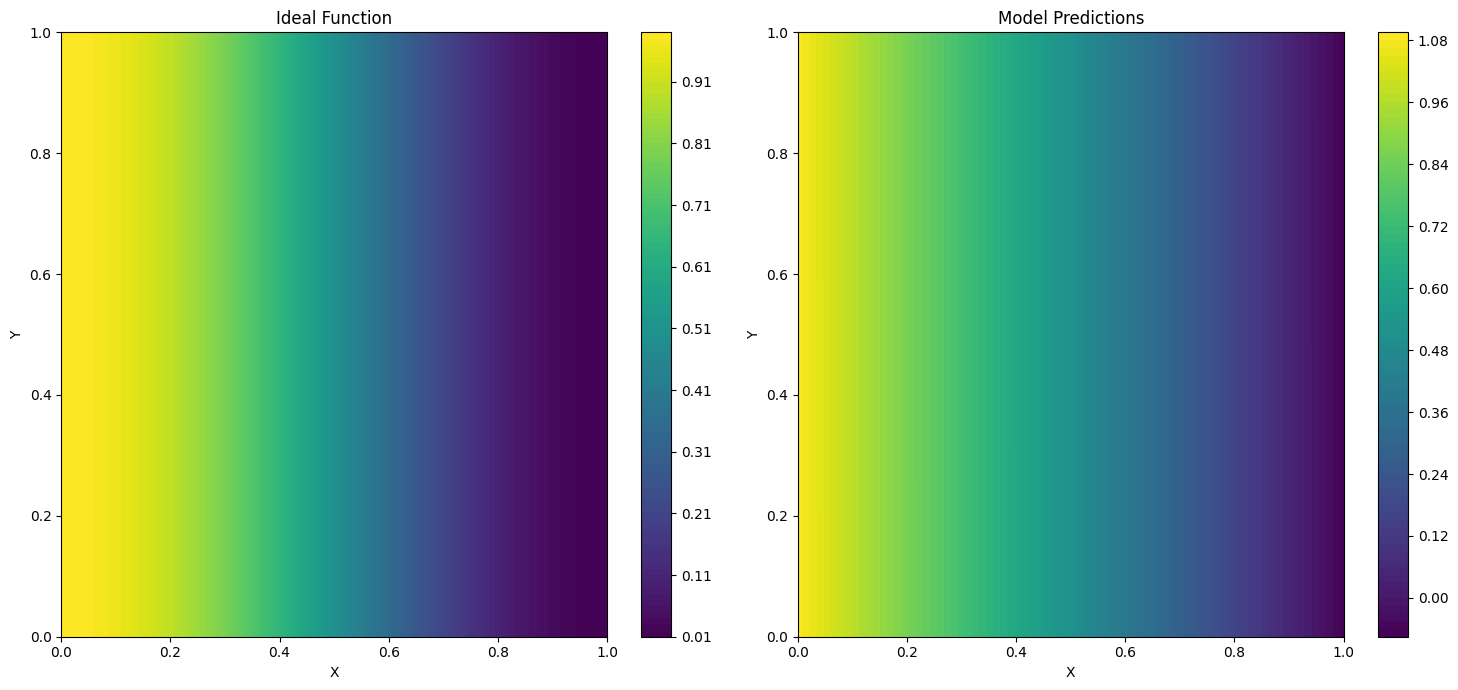

Training time: 27.352439688999766, mse: 0.00214722630244098, r2: 0.9825917151552429


In [13]:
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]
adam_steps = 50
time_best_lr_adam, mse_adam, r2_adam = train_classical_optimizer(dataset, degrees, "Adam", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.77e-01 | test loss: nan | reg: 2.74e+00 : 100%|███████| 50/50 [00:27<00:00,  1.84it/s]


Training time in seconds of lr=0.001: 27.11264975300037
Learning Rate: 0.001, Train MSE: 0.32924367655794917, Train r2: -1.66928907229767


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 3.96e-01 | test loss: nan | reg: 6.98e+00 : 100%|███████| 50/50 [00:27<00:00,  1.82it/s]


Training time in seconds of lr=0.01: 27.491393723999863
Learning Rate: 0.01, Train MSE: 0.14270849561883148, Train r2: -0.15698570694444425


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 2.99e-01 | test loss: nan | reg: 3.28e+00 : 100%|███████| 50/50 [00:26<00:00,  1.85it/s]


Training time in seconds of lr=0.05: 26.965674436999507
Learning Rate: 0.05, Train MSE: 0.08150884850400766, Train r2: 0.3391803879670867


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 2.00e-01 | test loss: nan | reg: 1.28e+00 : 100%|███████| 50/50 [00:26<00:00,  1.87it/s]


Training time in seconds of lr=0.1: 26.79322143400077
Learning Rate: 0.1, Train MSE: 0.014440399581510296, Train r2: 0.8829268303479384


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.16e-02 | test loss: nan | reg: 2.02e+00 : 100%|███████| 50/50 [00:27<00:00,  1.84it/s]


Training time in seconds of lr=0.2: 27.145215854000526
Learning Rate: 0.2, Train MSE: 0.0020868133627492623, Train r2: 0.9830815031488359


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.35e-01 | test loss: nan | reg: 2.32e+00 : 100%|███████| 50/50 [00:27<00:00,  1.85it/s]


Training time in seconds of lr=0.5: 27.01661835700088
Learning Rate: 0.5, Train MSE: 0.0056729081867902854, Train r2: 0.9540078279119748
Best Learning Rate: 0.2 with Train MSE: 0.0020868133627492623


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.16e-02 | test loss: nan | reg: 2.02e+00 : 100%|███████| 50/50 [00:26<00:00,  1.86it/s]


Training time in seconds: 26.9408677349993
Layer 0 Bezier coefficients:
[[-0.4256541   0.54015076]
 [ 0.05541704  0.05463625]]
Layer 1 Bezier coefficients:
[[ 0.54039425 -0.33809495]]


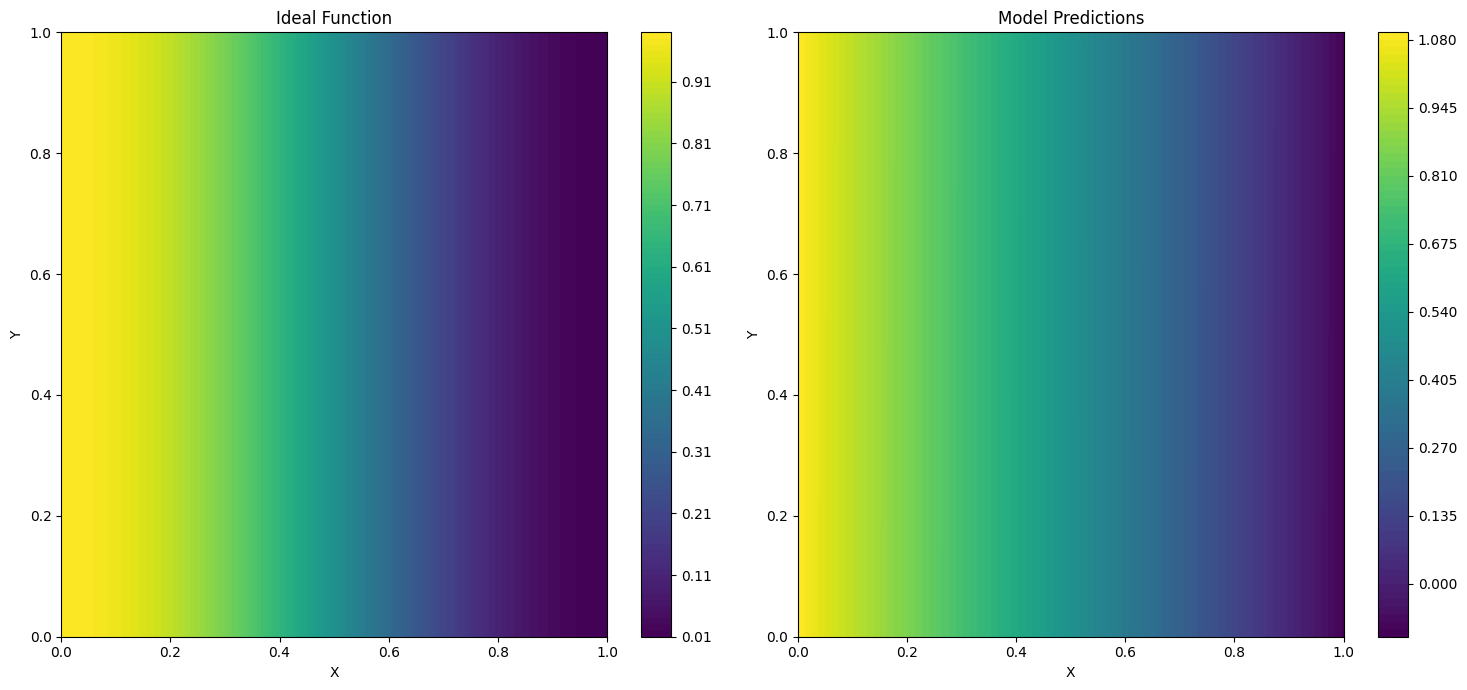

Training time: 26.9408677349993, mse: 0.00208680985046706, r2: 0.9830815316240874


In [14]:
time_best_lr_sgd, mse_sgd, r2_sgd = train_classical_optimizer(dataset, degrees, "SGD", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.97e-01 | test loss: nan | reg: 2.31e+00 : 100%|███████| 50/50 [00:27<00:00,  1.84it/s]


Training time in seconds of lr=0.001: 27.184382082999946
Learning Rate: 0.001, Train MSE: 0.35925023139166584, Train r2: -1.9125622909432018


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.44e-01 | test loss: nan | reg: 6.45e+00 : 100%|███████| 50/50 [00:27<00:00,  1.83it/s]


Training time in seconds of lr=0.01: 27.379525900000772
Learning Rate: 0.01, Train MSE: 0.17667425405728876, Train r2: -0.4323575190318325


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.00e-02 | test loss: nan | reg: 2.11e+00 : 100%|███████| 50/50 [00:28<00:00,  1.77it/s]


Training time in seconds of lr=0.05: 28.23709655499988
Learning Rate: 0.05, Train MSE: 0.0020777249584379327, Train r2: 0.9831551858952032


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.27e-02 | test loss: nan | reg: 1.18e+00 : 100%|███████| 50/50 [00:28<00:00,  1.76it/s]


Training time in seconds of lr=0.1: 28.37200539100013
Learning Rate: 0.1, Train MSE: 0.002106588422175676, Train r2: 0.9829211801000144


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.15e-02 | test loss: nan | reg: 1.60e+00 : 100%|███████| 50/50 [00:28<00:00,  1.77it/s]


Training time in seconds of lr=0.2: 28.269469742999718
Learning Rate: 0.2, Train MSE: 0.002089309724860103, Train r2: 0.9830612643027246


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.15e-02 | test loss: nan | reg: 9.61e-01 : 100%|███████| 50/50 [00:28<00:00,  1.77it/s]


Training time in seconds of lr=0.5: 28.221634167000957
Learning Rate: 0.5, Train MSE: 0.0020888822066459254, Train r2: 0.9830647303364819
Best Learning Rate: 0.05 with Train MSE: 0.0020777249584379327


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.99e-02 | test loss: nan | reg: 2.11e+00 : 100%|███████| 50/50 [00:28<00:00,  1.78it/s]


Training time in seconds: 28.05180057599864
Layer 0 Bezier coefficients:
[[-0.5336935   0.3894787 ]
 [-0.05965428 -0.06088857]]
Layer 1 Bezier coefficients:
[[ 0.26854998 -0.24889298]]


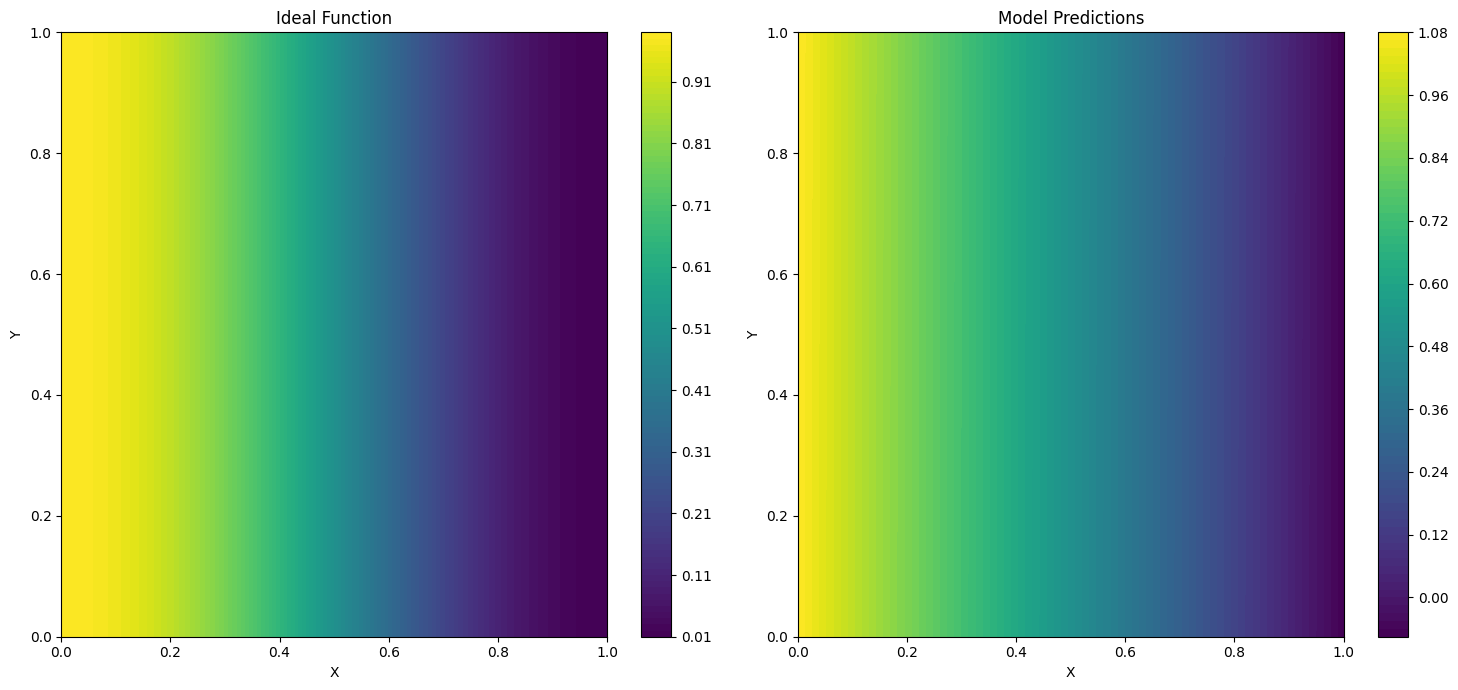

Training time: 28.05180057599864, mse: 0.0020779671051351094, r2: 0.9831532227305969


In [15]:
time_best_lr_adagrad, mse_adagrad, r2_adagrad = train_classical_optimizer(dataset, degrees, "AdaGrad", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

In [16]:
total_time_quantum.append(quantum_total_time_optimization)
total_time_hybrid.append(hybrid_total_time_optimization)
total_time_simulated.append(simulated_total_time_optimization)
total_time_adam.append(time_best_lr_adam)
total_time_sgd.append(time_best_lr_sgd)
total_time_adagrad.append(time_best_lr_adagrad)

print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {quantum_total_time_optimization}")
print(f"MSE: {quantum_mse:.4f}, r2: {quantum_r2:.4f}")

print("Hybrid Quantum Annealing Metrics:")
print(f"Total run time in seconds: {hybrid_total_time_optimization}")
print(f"MSE: {hybrid_mse:.4f}, r2: {hybrid_r2:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {simulated_total_time_optimization}")
print(f"MSE: {simulated_mse:.4f}, r2: {simulated_r2:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adam}")
print(f"MSE: {mse_adam:.4f}, r2: {r2_adam:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_sgd}")
print(f"MSE: {mse_sgd:.4f}, r2: {r2_sgd:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adagrad}")
print(f"MSE: {mse_adagrad:.4f}, r2: {r2_adagrad:.4f}")

Quantum Annealing Metrics:
Total run time in seconds: 0.8389014680008096
MSE: 0.0027, r2: 0.9784
Hybrid Quantum Annealing Metrics:
Total run time in seconds: 3.494058329001469
MSE: 0.0027, r2: 0.9784
Simulated Annealing Metrics
Total run time in seconds: 10.444197157000417
MSE: 0.0027, r2: 0.9784
Adam Optimizer Metrics
Total run time in seconds: 27.352439688999766
MSE: 0.0021, r2: 0.9826
SGD Optimizer Metrics
Total run time in seconds: 26.9408677349993
MSE: 0.0021, r2: 0.9831
AdaGrad Optimizer Metrics
Total run time in seconds: 28.05180057599864
MSE: 0.0021, r2: 0.9832


# Now lets add a few more datapoints to make dataset 2

In [17]:
dataset_1 = dataset
X_1 = X
y_1 = 1
x_data_1 = x_data
y_data_1 = y_data
z_data_1 = z_data

In [18]:
dataset = dataset_split1
X = dataset['train_input']
y = dataset['train_label']
x_data = X[:, 0].numpy()
y_data = X[:, 1].numpy()
z_data = y[:, 0].numpy()

In [19]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist(),
    save_filename=save_file2, load_filename=save_file1
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
# Mapping for P variables
for var in sorted(Solving_for_vars):
    var = str(var)
    if '_' in var:
        parts = var.split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]

# Mapping for AUX variables
aux_var_to_index = {var: idx for idx, var in enumerate(aux_dict_str.keys())}
for aux_var in aux_dict_str.keys():
    sympy_to_pyqubo_map[f"{aux_var}"] = coefficients_aux[aux_var_to_index[aux_var]]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm) #* 2.0

end_time_quantum_part1 = time.perf_counter()

In [20]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 0.1331789639989438


In [21]:
# Combine datasets
combined_train_input = torch.cat((dataset_1['train_input'], dataset['train_input']), dim=0)
combined_train_label = torch.cat((dataset_1['train_label'], dataset['train_label']), dim=0)
combined_test_input = torch.cat((dataset_1['test_input'], dataset['test_input']), dim=0)
combined_test_label = torch.cat((dataset_1['test_label'], dataset['test_label']), dim=0)
combined_dataset_2 = {
    'train_input': combined_train_input,
    'train_label': combined_train_label,
    'test_input': combined_test_input,
    'test_label': combined_test_label
}

Timing Information:
qpu_sampling_time: 197560.0 microseconds
qpu_anneal_time_per_sample: 20.0 microseconds
qpu_readout_time_per_sample: 58.21 microseconds
qpu_access_time: 216787.62 microseconds
qpu_access_overhead_time: 2014.38 microseconds
qpu_programming_time: 19227.62 microseconds
qpu_delay_time_per_sample: 20.57 microseconds
post_processing_overhead_time: 7.0 microseconds
total_post_processing_time: 7.0 microseconds

QPU Access Time: 216787.62 microseconds
Time spent on quantum annealer part 2: 0.21678762
Time spent on part 3: 0.0009111890012718504
Time spent on optimization: 0.3508777730002156
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [1.0, 0.5]
optimized_coefficients_3: [1.5, 0.75]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AUX

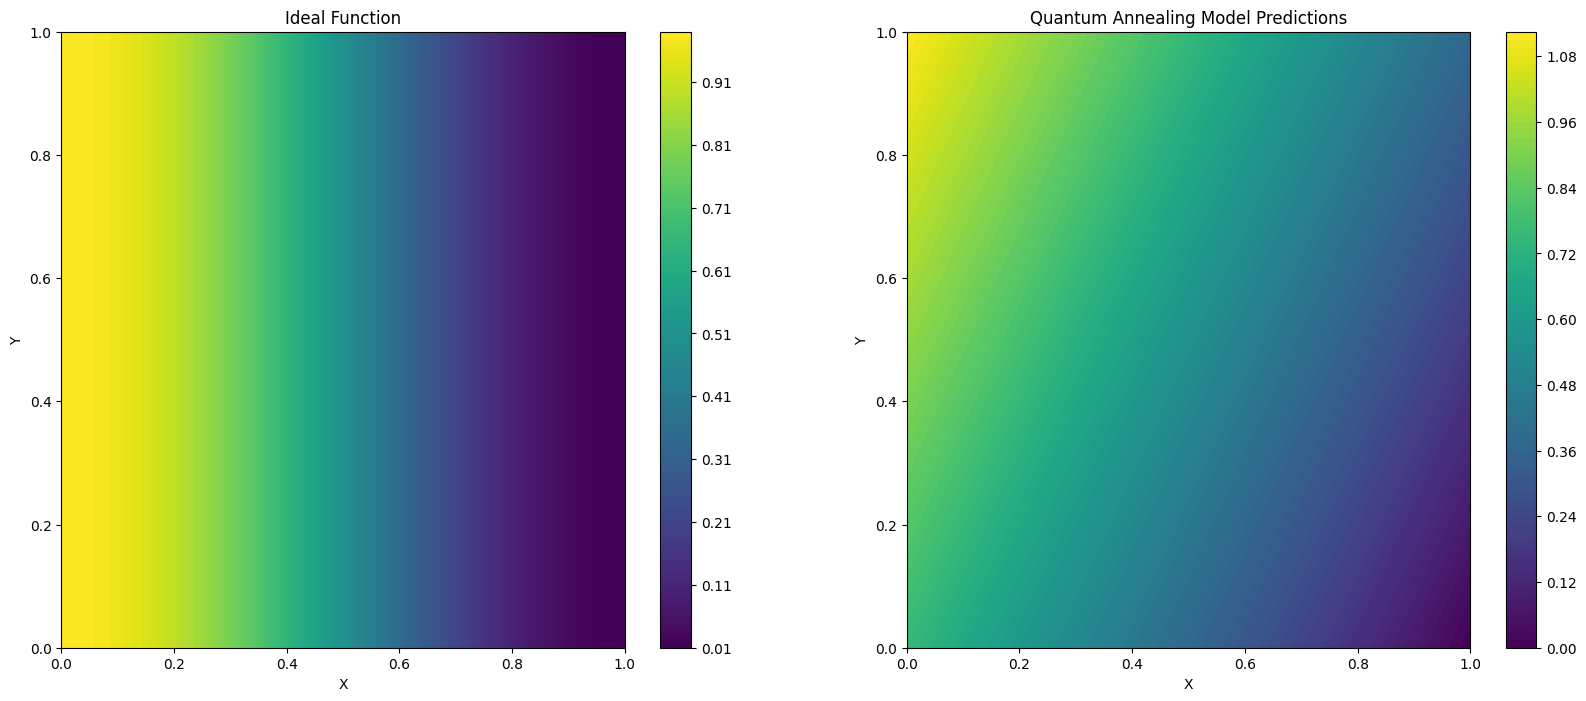

In [22]:
quantum_time_part2, quantum_time_part3, quantum_total_time_optimization, quantum_mse, quantum_r2 = run_annealing("QA", sampler, bqm, chain_strength * 0.5, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=2000)

Timing Information:
qpu_access_time: 125565 microseconds
charge_time: 2993098 microseconds
run_time: 2993098 microseconds
problem_id: 9decd4e1-de5b-4b78-88b5-067f13698194 microseconds

QPU Access Time: 125565 microseconds

Total D-Wave Run Time Including Setup: 2993098 microseconds
Time spent on hybrid part 2: 2.993098
Time spent on part 3: 0.0006206880007084692
Time spent on optimization: 3.126897651999652
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 0.5]
optimized_coefficients_3: [1.5, 0.5]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX2: Correct
AUX27: Correct
AUX36: Correct
AUX1: Correct
AUX7: Correct
AUX40: Correct
AUX3: Correct
AUX29: Correct
AUX41: Co

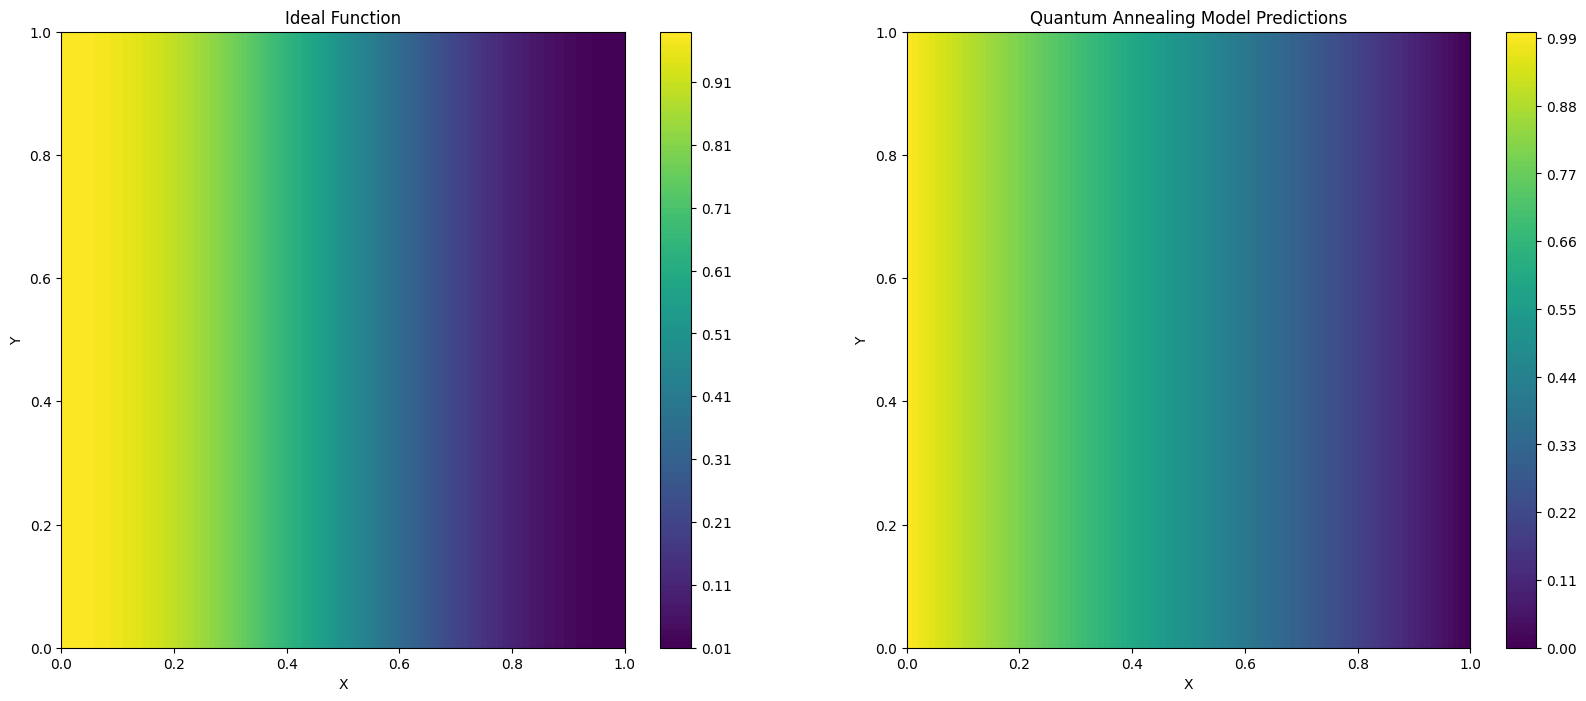

In [23]:
hybrid_time_part2, hybrid_time_part3, hybrid_total_time_optimization, hybrid_mse, hybrid_r2 = run_annealing("HQA", hybrid_sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=2000)

Time spent on simulated part 2: 10.19269751200045
Time spent on part 3: 0.001450151001336053
Time spent on optimization: 10.32732662700073
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX2: Correct
AUX27: Correct
AUX36: Correct
AUX1: Correct
AUX7: Correct
AUX40: Correct
AUX3: Correct
AUX29: Correct
AUX41: Correct
AUX30: Correct
AUX34: Correct
AUX23: Correct
AUX4: Correct
AUX31: Correct
AUX32: Correct
AUX35: Correct
AUX13: Correct
Training time: 10.32732662700073, MSE: 0.0027, r2: 0.9784
time_part1: 0.1331789639989438, time_part2: 10.19269751200045, time_part3: 0.00145015100

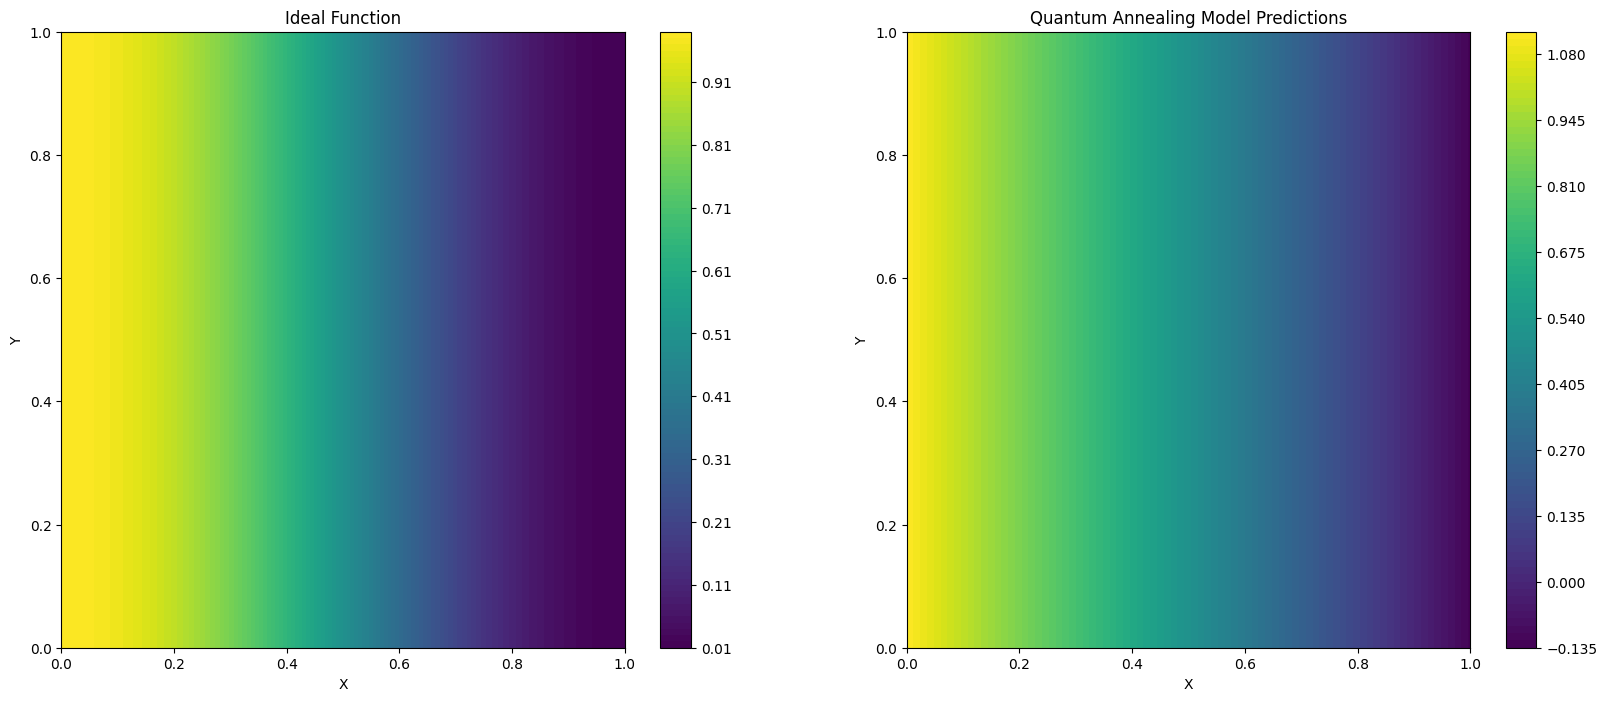

In [24]:
simulated_time_part2, simulated_time_part3, simulated_total_time_optimization, simulated_mse, simulated_r2 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=10000)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.54e-02 | test loss: nan | reg: 1.63e+00 : 100%|███████| 50/50 [00:31<00:00,  1.60it/s]


Training time in seconds of lr=0.05: 31.31054709899945
Learning Rate: 0.05, Train MSE: 0.002147779609606882, Train r2: 0.9825872293082041


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.56e-02 | test loss: nan | reg: 1.29e+00 : 100%|███████| 50/50 [00:30<00:00,  1.63it/s]


Training time in seconds of lr=0.1: 30.59228901899951
Learning Rate: 0.1, Train MSE: 0.002459089390028416, Train r2: 0.9800633363555254


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.23e-02 | test loss: nan | reg: 1.17e+00 : 100%|███████| 50/50 [00:29<00:00,  1.67it/s]


Training time in seconds of lr=0.2: 29.891460217000713
Learning Rate: 0.2, Train MSE: 0.0025899520888708573, Train r2: 0.9790023885018162
Best Learning Rate: 0.05 with Train MSE: 0.002147779609606882


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.54e-02 | test loss: nan | reg: 1.64e+00 : 100%|███████| 50/50 [00:29<00:00,  1.67it/s]


Training time in seconds: 29.905476529000225
Layer 0 Bezier coefficients:
[[-0.95235276  0.5622793 ]
 [ 0.09503812  0.09630157]]
Layer 1 Bezier coefficients:
[[ 0.37794265 -0.1587989 ]]


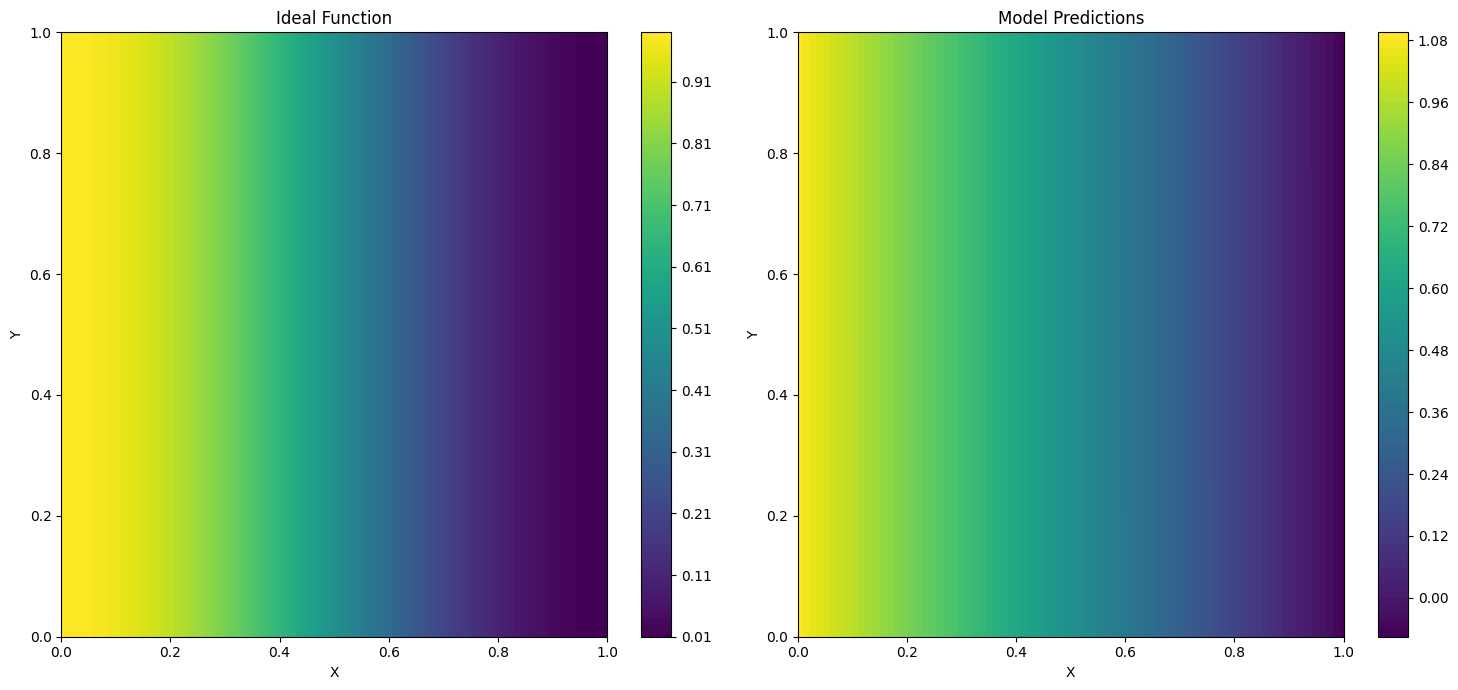

Training time: 29.905476529000225, mse: 0.0021434146428027296, r2: 0.9826226175601913


In [25]:
learning_rates = [0.05, 0.1, 0.2]
time_best_lr_adam, mse_adam, r2_adam = train_classical_optimizer(combined_dataset_2, degrees, "Adam", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 2.99e-01 | test loss: nan | reg: 3.29e+00 : 100%|███████| 50/50 [00:30<00:00,  1.66it/s]


Training time in seconds of lr=0.05: 30.08307731000059
Learning Rate: 0.05, Train MSE: 0.08154887441887095, Train r2: 0.3388558844313765


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.99e-01 | test loss: nan | reg: 1.29e+00 : 100%|███████| 50/50 [00:29<00:00,  1.68it/s]


Training time in seconds of lr=0.1: 29.849019179000607
Learning Rate: 0.1, Train MSE: 0.014432117233425497, Train r2: 0.8829939781257389


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.16e-02 | test loss: nan | reg: 2.02e+00 : 100%|███████| 50/50 [00:29<00:00,  1.69it/s]


Training time in seconds of lr=0.2: 29.59901962600088
Learning Rate: 0.2, Train MSE: 0.0020864944357167963, Train r2: 0.9830840887974094
Best Learning Rate: 0.2 with Train MSE: 0.0020864944357167963


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.16e-02 | test loss: nan | reg: 2.02e+00 : 100%|███████| 50/50 [00:29<00:00,  1.68it/s]


Training time in seconds: 29.691596843000298
Layer 0 Bezier coefficients:
[[-0.42566243  0.5403229 ]
 [ 0.05541482  0.05456376]]
Layer 1 Bezier coefficients:
[[ 0.54036427 -0.33775094]]


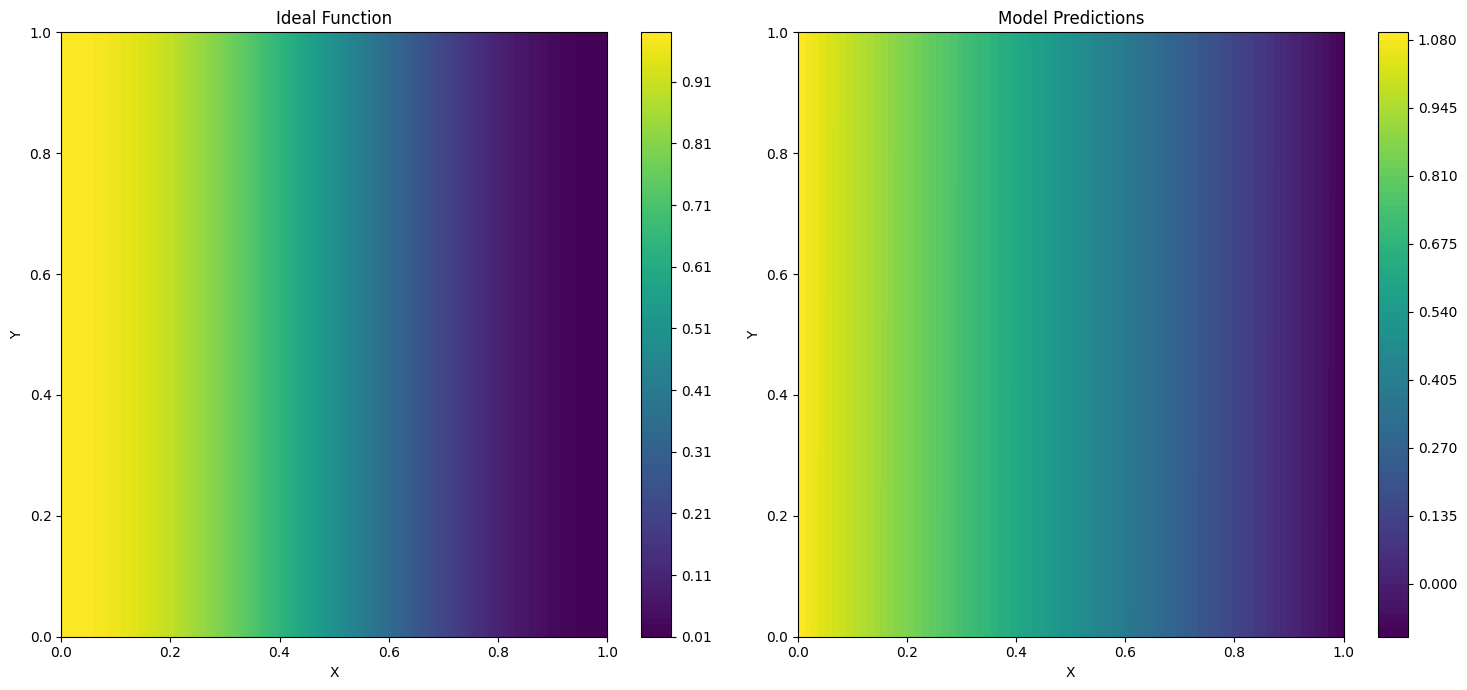

Training time: 29.691596843000298, mse: 0.0020864643810025994, r2: 0.9830843324610722


In [26]:
time_best_lr_sgd, mse_sgd, r2_sgd = train_classical_optimizer(combined_dataset_2, degrees, "SGD", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.99e-02 | test loss: nan | reg: 2.11e+00 : 100%|███████| 50/50 [00:29<00:00,  1.68it/s]


Training time in seconds of lr=0.05: 29.792517481000687
Learning Rate: 0.05, Train MSE: 0.002077832513237136, Train r2: 0.9831543139123206


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.28e-02 | test loss: nan | reg: 1.18e+00 : 100%|███████| 50/50 [00:30<00:00,  1.66it/s]


Training time in seconds of lr=0.1: 30.124417807999635
Learning Rate: 0.1, Train MSE: 0.002109233898229231, Train r2: 0.9828997323370852


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.15e-02 | test loss: nan | reg: 1.60e+00 : 100%|███████| 50/50 [00:29<00:00,  1.68it/s]


Training time in seconds of lr=0.2: 29.688964652001232
Learning Rate: 0.2, Train MSE: 0.002089344546787385, Train r2: 0.9830609819896642
Best Learning Rate: 0.05 with Train MSE: 0.002077832513237136


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.97e-02 | test loss: nan | reg: 2.09e+00 : 100%|███████| 50/50 [00:29<00:00,  1.67it/s]


Training time in seconds: 29.951044262999858
Layer 0 Bezier coefficients:
[[-0.5332464   0.38936287]
 [-0.05804444 -0.05944332]]
Layer 1 Bezier coefficients:
[[ 0.2695241  -0.24879704]]


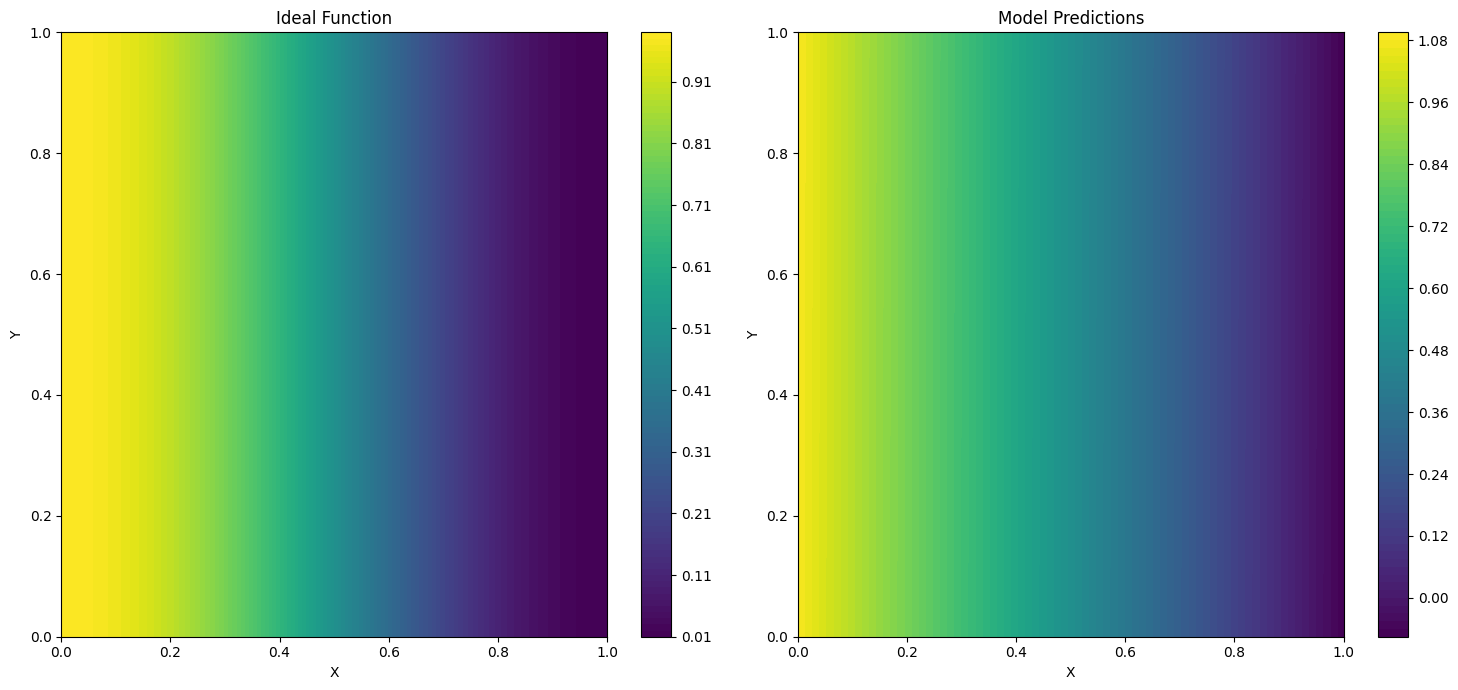

Training time: 29.951044262999858, mse: 0.002076504865589916, r2: 0.9831650775977271


In [27]:
time_best_lr_adagrad, mse_adagrad, r2_adagrad = train_classical_optimizer(combined_dataset_2, degrees, "AdaGrad", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

In [28]:
total_time_quantum.append(quantum_total_time_optimization)
total_time_hybrid.append(hybrid_total_time_optimization)
total_time_simulated.append(simulated_total_time_optimization)
total_time_adam.append(time_best_lr_adam)
total_time_sgd.append(time_best_lr_sgd)
total_time_adagrad.append(time_best_lr_adagrad)

print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {quantum_total_time_optimization}")
print(f"MSE: {quantum_mse:.4f}, r2: {quantum_r2:.4f}")

print("Hybrid Quantum Annealing Metrics:")
print(f"Total run time in seconds: {hybrid_total_time_optimization}")
print(f"MSE: {hybrid_mse:.4f}, r2: {hybrid_r2:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {simulated_total_time_optimization}")
print(f"MSE: {simulated_mse:.4f}, r2: {simulated_r2:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adam}")
print(f"MSE: {mse_adam:.4f}, r2: {r2_adam:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_sgd}")
print(f"MSE: {mse_sgd:.4f}, r2: {r2_sgd:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adagrad}")
print(f"MSE: {mse_adagrad:.4f}, r2: {r2_adagrad:.4f}")

# Total run times so far:
print(f"Array of time for quantum in each training/retraining: {total_time_quantum}, total time: {sum(total_time_quantum)}")
print(f"Array of time for hybrid in each training/retraining: {total_time_hybrid}, total time: {sum(total_time_hybrid)}")
print(f"Array of time for simulated in each training/retraining: {total_time_simulated}, total time: {sum(total_time_simulated)}")
print(f"Array of time for adam in each training/retraining: {total_time_adam}, total time: {sum(total_time_adam)}")
print(f"Array of time for SDG in each training/retraining: {total_time_sgd}, total time: {sum(total_time_sgd)}")
print(f"Array of time for adagrad in each training/retraining: {total_time_adagrad}, total time: {sum(total_time_adagrad)}")

Quantum Annealing Metrics:
Total run time in seconds: 0.3508777730002156
MSE: 0.0340, r2: 0.7246
Hybrid Quantum Annealing Metrics:
Total run time in seconds: 3.126897651999652
MSE: 0.0045, r2: 0.9633
Simulated Annealing Metrics
Total run time in seconds: 10.32732662700073
MSE: 0.0027, r2: 0.9784
Adam Optimizer Metrics
Total run time in seconds: 29.905476529000225
MSE: 0.0021, r2: 0.9826
SGD Optimizer Metrics
Total run time in seconds: 29.691596843000298
MSE: 0.0021, r2: 0.9831
AdaGrad Optimizer Metrics
Total run time in seconds: 29.951044262999858
MSE: 0.0021, r2: 0.9832
Array of time for quantum in each training/retraining: [0.8389014680008096, 0.3508777730002156], total time: 1.189779241001025
Array of time for hybrid in each training/retraining: [3.494058329001469, 3.126897651999652], total time: 6.620955981001121
Array of time for simulated in each training/retraining: [10.444197157000417, 10.32732662700073], total time: 20.771523784001147
Array of time for adam in each training/re

# Adding a few more datapoints to make dataset 3

In [29]:
dataset_2 = dataset
X_2 = X
y_2 = 1
x_data_2 = x_data
y_data_2 = y_data
z_data_2 = z_data

In [30]:
dataset = dataset_split2
X = dataset['train_input']
y = dataset['train_label']
x_data = X[:, 0].numpy()
y_data = X[:, 1].numpy()
z_data = y[:, 0].numpy()

In [31]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist(),
    save_filename=save_file3, load_filename=save_file2
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
# Mapping for P variables
for var in sorted(Solving_for_vars):
    var = str(var)
    if '_' in var:
        parts = var.split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]

# Mapping for AUX variables
aux_var_to_index = {var: idx for idx, var in enumerate(aux_dict_str.keys())}
for aux_var in aux_dict_str.keys():
    sympy_to_pyqubo_map[f"{aux_var}"] = coefficients_aux[aux_var_to_index[aux_var]]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm) #* 2.0

end_time_quantum_part1 = time.perf_counter()

In [32]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 0.11851416700119444


In [33]:
# Combine datasets
combined_train_input = torch.cat((dataset_2['train_input'], dataset_1['train_input'], dataset['train_input']), dim=0)
combined_train_label = torch.cat((dataset_2['train_label'], dataset_1['train_label'], dataset['train_label']), dim=0)
combined_test_input = torch.cat((dataset_2['test_input'], dataset_1['test_input'], dataset['test_input']), dim=0)
combined_test_label = torch.cat((dataset_2['test_label'], dataset_1['test_label'], dataset['test_label']), dim=0)
combined_dataset_3 = {
    'train_input': combined_train_input,
    'train_label': combined_train_label,
    'test_input': combined_test_input,
    'test_label': combined_test_label
}

Timing Information:
qpu_sampling_time: 237560.0 microseconds
qpu_anneal_time_per_sample: 20.0 microseconds
qpu_readout_time_per_sample: 78.21 microseconds
qpu_access_time: 256788.02 microseconds
qpu_access_overhead_time: 2823.98 microseconds
qpu_programming_time: 19228.02 microseconds
qpu_delay_time_per_sample: 20.57 microseconds
post_processing_overhead_time: 322.0 microseconds
total_post_processing_time: 322.0 microseconds

QPU Access Time: 256788.02 microseconds
Time spent on quantum annealer part 2: 0.25678801999999995
Time spent on part 3: 0.0008660679995955434
Time spent on optimization: 0.37616825500078993
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [1.5, 1.5]
optimized_coefficients_3: [1.75, 1.0]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX1

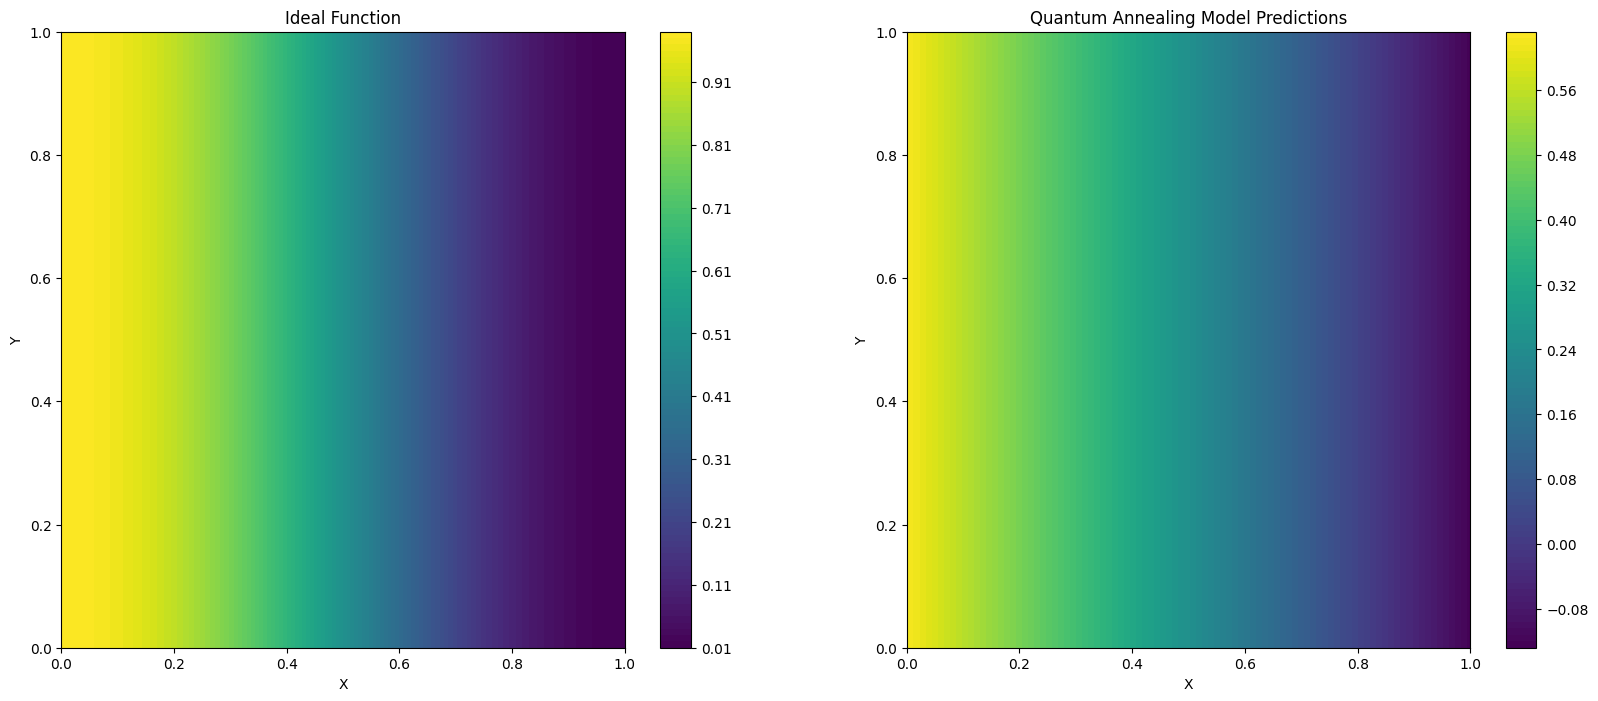

In [34]:
quantum_time_part2, quantum_time_part3, quantum_total_time_optimization, quantum_mse, quantum_r2 = run_annealing("QA", sampler, bqm, chain_strength * 0.5, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=2000)

Timing Information:
qpu_access_time: 182158 microseconds
charge_time: 2988081 microseconds
run_time: 2988081 microseconds
problem_id: 99addeb9-8001-47d5-801b-615f8f9d5e80 microseconds

QPU Access Time: 182158 microseconds

Total D-Wave Run Time Including Setup: 2988081 microseconds
Time spent on hybrid part 2: 2.9880809999999998
Time spent on part 3: 0.0006028870011505205
Time spent on optimization: 3.1071980540023447
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX2: Correct
AUX27: Correct
AUX36: Correct
AUX1: Correct
AUX7: Correct
AUX40: Correct
AUX3: Correct
AUX29: Corre

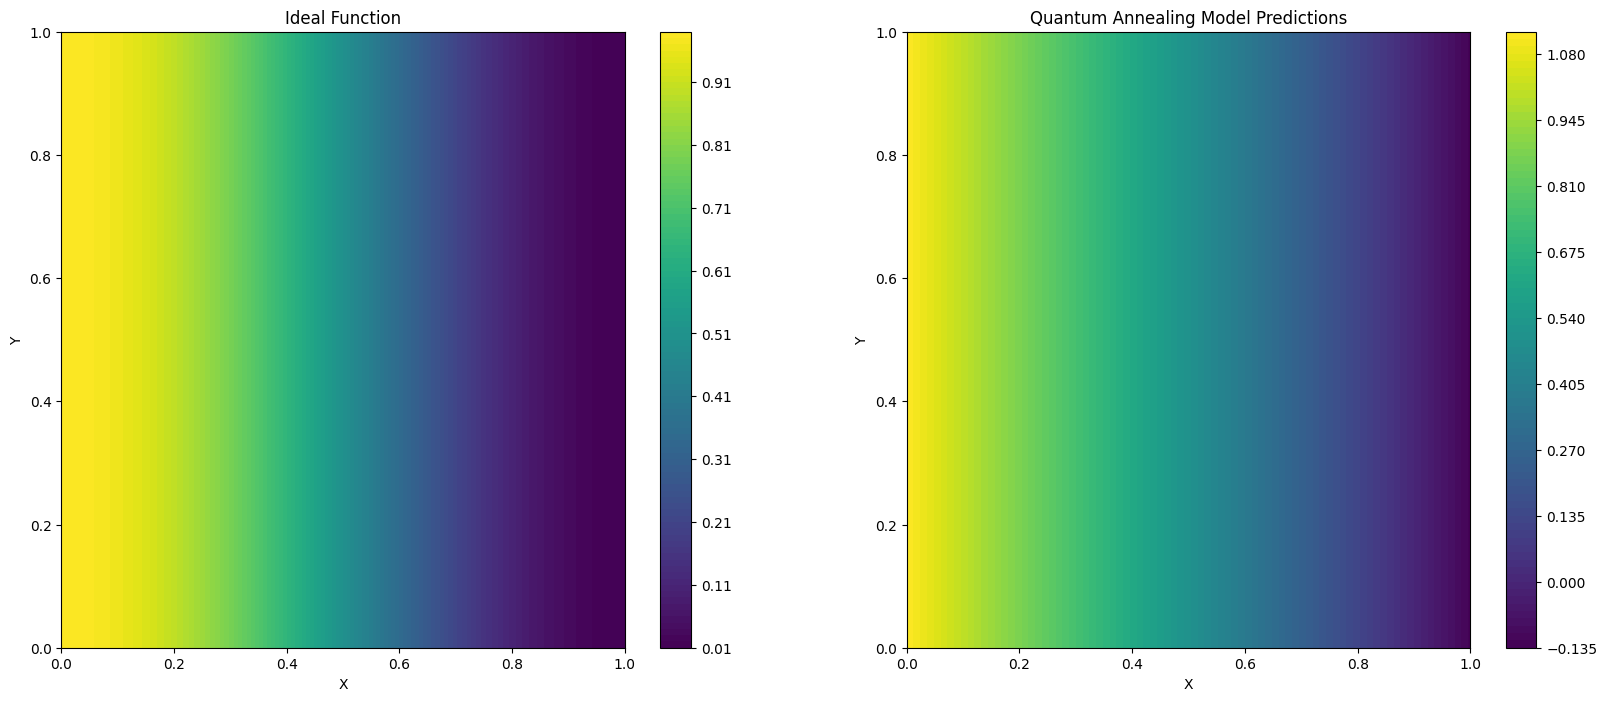

In [35]:
hybrid_time_part2, hybrid_time_part3, hybrid_total_time_optimization, hybrid_mse, hybrid_r2 = run_annealing("HQA", hybrid_sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=2000)

Time spent on simulated part 2: 9.932155817999956
Time spent on part 3: 0.0013671050000994
Time spent on optimization: 10.05203709000125
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX2: Correct
AUX27: Correct
AUX36: Correct
AUX1: Correct
AUX7: Correct
AUX40: Correct
AUX3: Correct
AUX29: Correct
AUX41: Correct
AUX30: Correct
AUX34: Correct
AUX23: Correct
AUX4: Correct
AUX31: Correct
AUX32: Correct
AUX35: Correct
AUX13: Correct
Training time: 10.05203709000125, MSE: 0.0027, r2: 0.9784
time_part1: 0.11851416700119444, time_part2: 9.932155817999956, time_part3: 0.001367105000

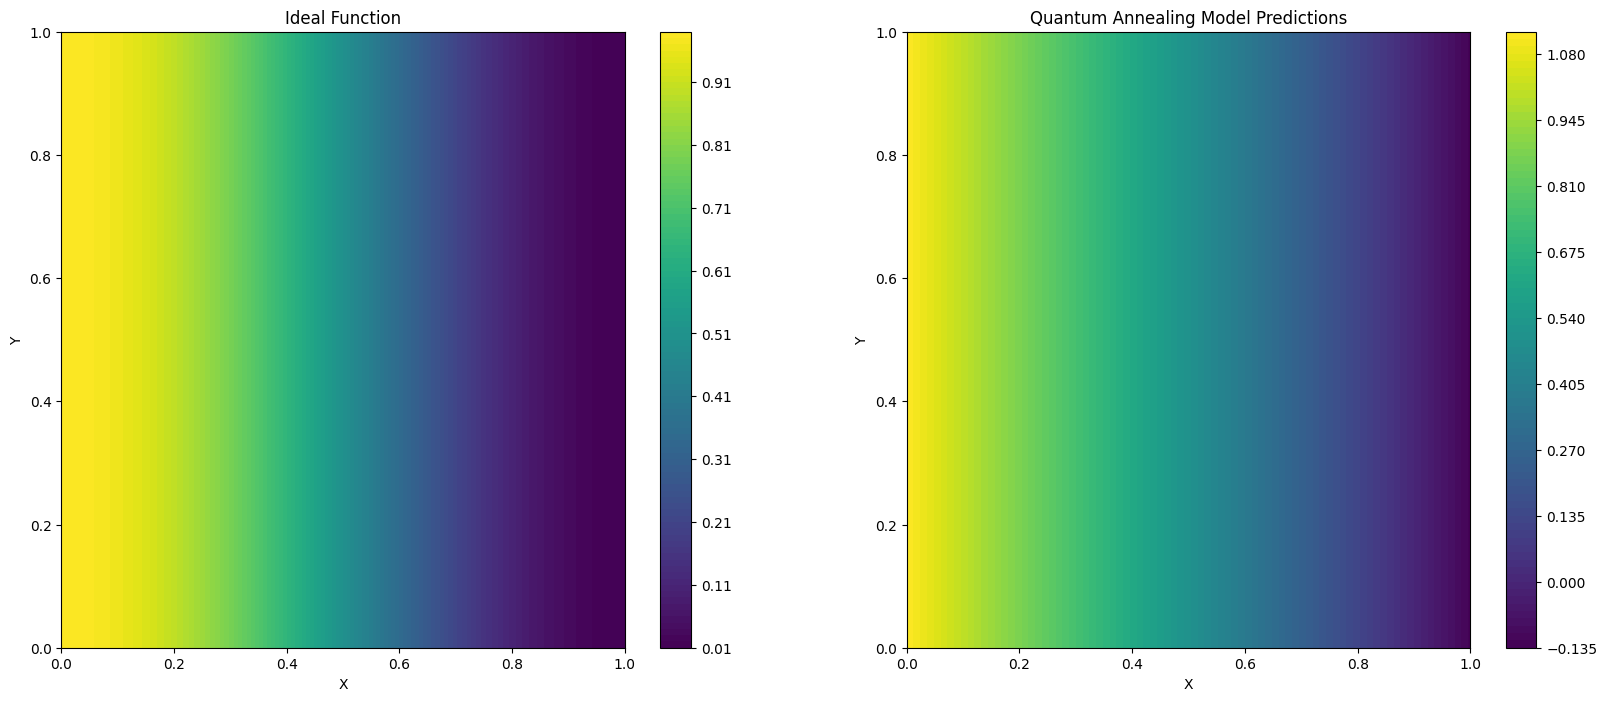

In [36]:
simulated_time_part2, simulated_time_part3, simulated_total_time_optimization, simulated_mse, simulated_r2 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=10000)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.58e-02 | test loss: nan | reg: 1.63e+00 : 100%|███████| 50/50 [00:33<00:00,  1.51it/s]


Training time in seconds of lr=0.05: 33.177107822000835
Learning Rate: 0.05, Train MSE: 0.0021472424245900174, Train r2: 0.9825915844475656


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.57e-02 | test loss: nan | reg: 1.29e+00 : 100%|███████| 50/50 [00:33<00:00,  1.51it/s]


Training time in seconds of lr=0.1: 33.149728824000704
Learning Rate: 0.1, Train MSE: 0.0024611366563406273, Train r2: 0.9800467384798961


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.20e-02 | test loss: nan | reg: 1.16e+00 : 100%|███████| 50/50 [00:33<00:00,  1.48it/s]


Training time in seconds of lr=0.2: 33.790773844000796
Learning Rate: 0.2, Train MSE: 0.002619595215973946, Train r2: 0.978762061713851
Best Learning Rate: 0.05 with Train MSE: 0.0021472424245900174


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.53e-02 | test loss: nan | reg: 1.64e+00 : 100%|███████| 50/50 [00:33<00:00,  1.51it/s]


Training time in seconds: 33.15014429599978
Layer 0 Bezier coefficients:
[[-0.9527817   0.56217206]
 [ 0.09586175  0.09697717]]
Layer 1 Bezier coefficients:
[[ 0.37829974 -0.15921837]]


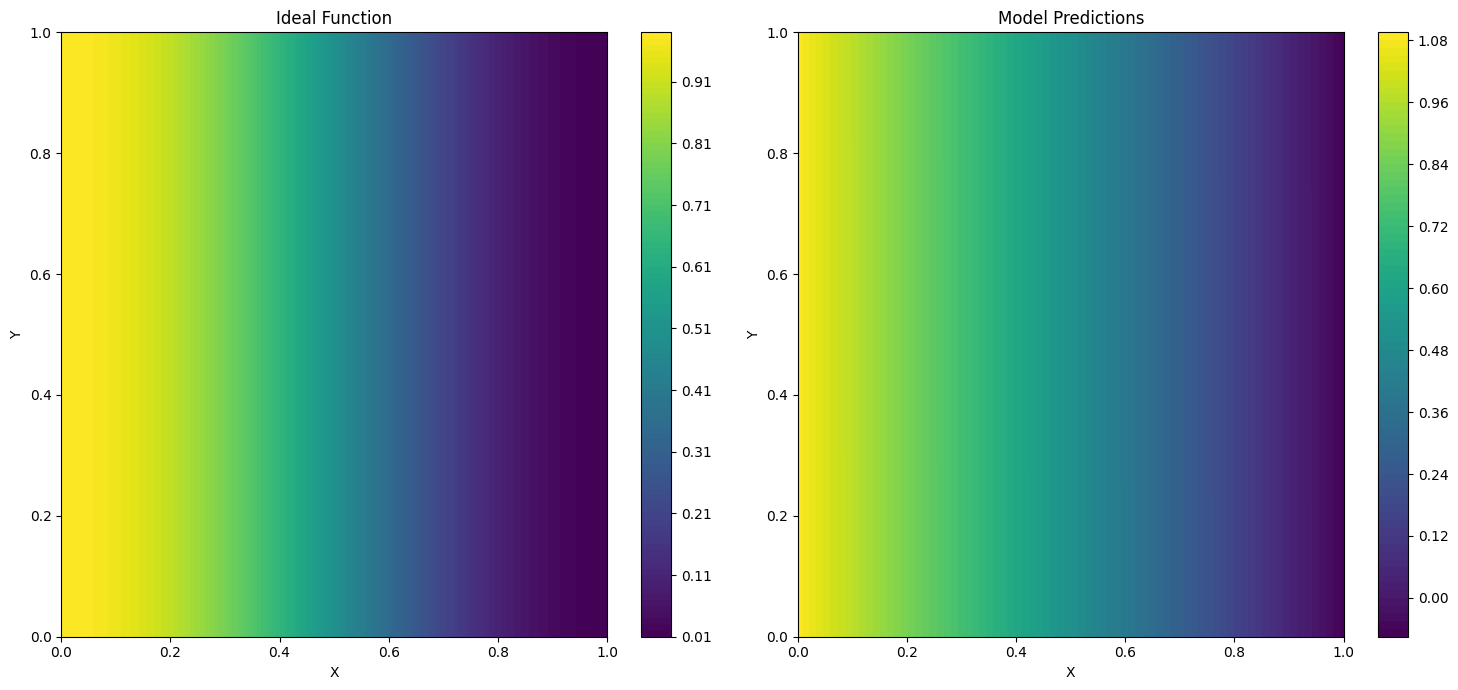

Training time: 33.15014429599978, mse: 0.002143934650386147, r2: 0.9826184016840523


In [37]:
time_best_lr_adam, mse_adam, r2_adam = train_classical_optimizer(combined_dataset_3, degrees, "Adam", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 2.99e-01 | test loss: nan | reg: 3.28e+00 : 100%|███████| 50/50 [00:33<00:00,  1.51it/s]


Training time in seconds of lr=0.05: 33.199669153000286
Learning Rate: 0.05, Train MSE: 0.08148658206472936, Train r2: 0.33936090946917263


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 2.10e-01 | test loss: nan | reg: 1.28e+00 : 100%|███████| 50/50 [00:32<00:00,  1.53it/s]


Training time in seconds of lr=0.1: 32.757981671999005
Learning Rate: 0.1, Train MSE: 0.017288890311053944, Train r2: 0.8598331592518017


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.17e-02 | test loss: nan | reg: 2.06e+00 : 100%|███████| 50/50 [00:33<00:00,  1.51it/s]


Training time in seconds of lr=0.2: 33.133864738998454
Learning Rate: 0.2, Train MSE: 0.002085747335365377, Train r2: 0.9830901457908946
Best Learning Rate: 0.2 with Train MSE: 0.002085747335365377


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.17e-02 | test loss: nan | reg: 2.06e+00 : 100%|███████| 50/50 [00:33<00:00,  1.49it/s]


Training time in seconds: 33.47031396299826
Layer 0 Bezier coefficients:
[[-0.43039268  0.55774224]
 [ 0.06109511  0.05999826]]
Layer 1 Bezier coefficients:
[[ 0.55064875 -0.30369416]]


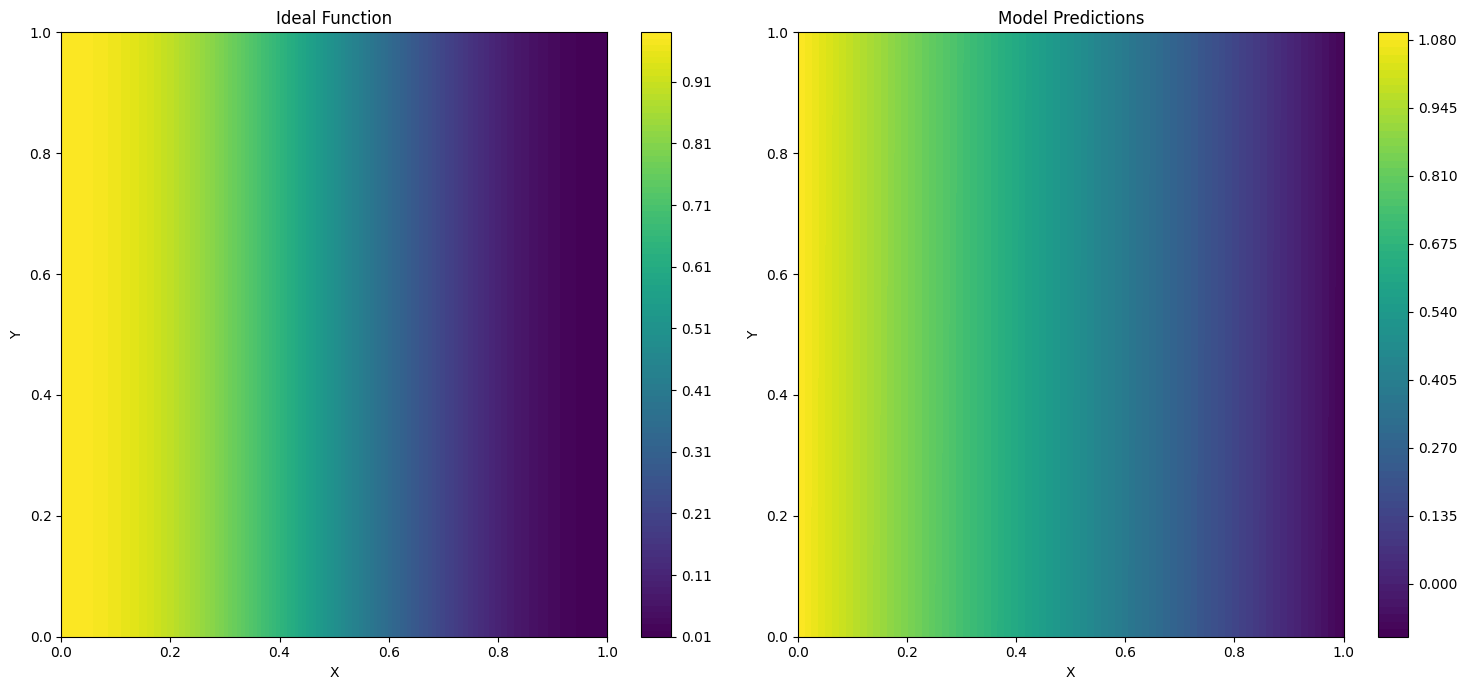

Training time: 33.47031396299826, mse: 0.002085693492239903, r2: 0.9830905823151976


In [38]:
time_best_lr_sgd, mse_sgd, r2_sgd = train_classical_optimizer(combined_dataset_3, degrees, "SGD", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.99e-02 | test loss: nan | reg: 2.11e+00 : 100%|███████| 50/50 [00:32<00:00,  1.52it/s]


Training time in seconds of lr=0.05: 32.97556083000018
Learning Rate: 0.05, Train MSE: 0.002077866243896027, Train r2: 0.9831540404465394


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.15e-02 | test loss: nan | reg: 1.69e+00 : 100%|███████| 50/50 [00:32<00:00,  1.54it/s]


Training time in seconds of lr=0.1: 32.55737910000062
Learning Rate: 0.1, Train MSE: 0.002088564862477871, Train r2: 0.9830673031522419


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.15e-02 | test loss: nan | reg: 1.60e+00 : 100%|███████| 50/50 [00:32<00:00,  1.54it/s]


Training time in seconds of lr=0.2: 32.42802734500037
Learning Rate: 0.2, Train MSE: 0.0020890714178248837, Train r2: 0.9830631963379017
Best Learning Rate: 0.05 with Train MSE: 0.002077866243896027


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.98e-02 | test loss: nan | reg: 2.10e+00 : 100%|███████| 50/50 [00:32<00:00,  1.52it/s]


Training time in seconds: 32.94802478699967
Layer 0 Bezier coefficients:
[[-0.5331649   0.3893234 ]
 [-0.05845074 -0.05988206]]
Layer 1 Bezier coefficients:
[[ 0.26928836 -0.24894485]]


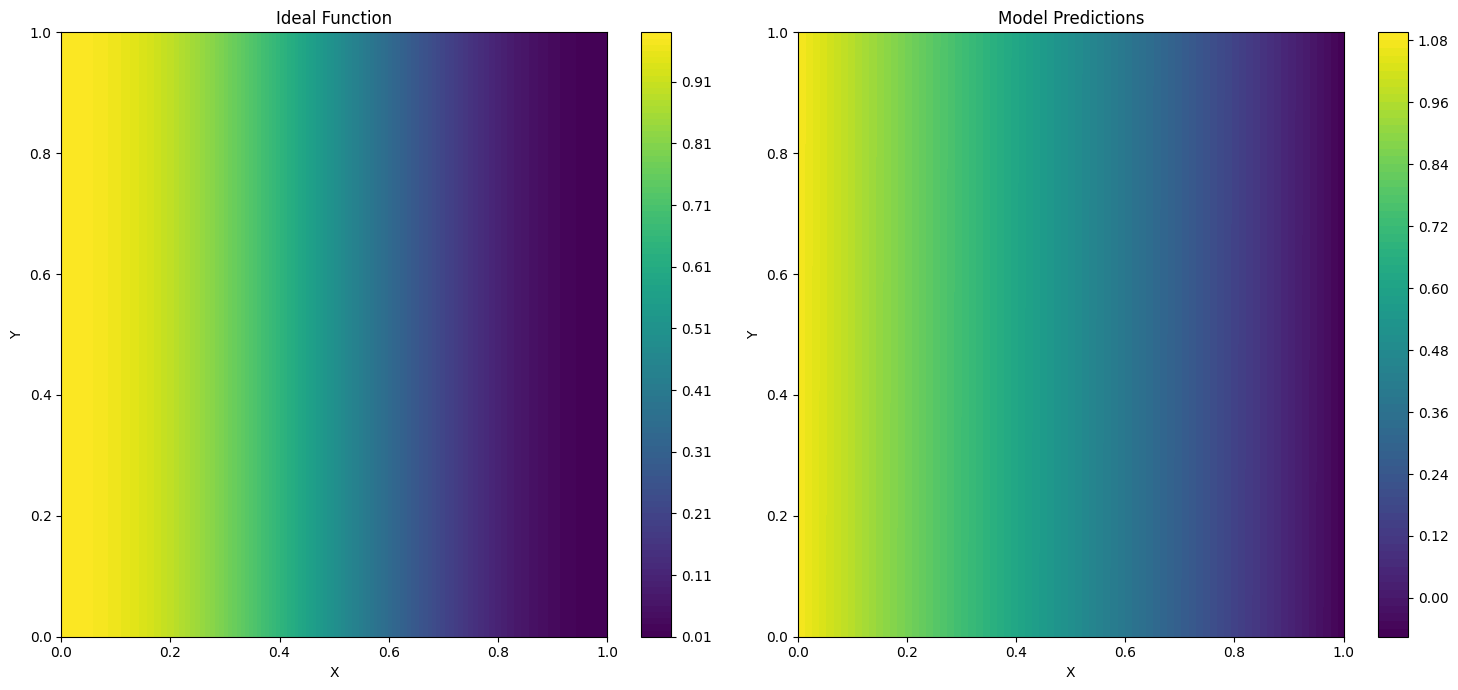

Training time: 32.94802478699967, mse: 0.0020768629586712874, r2: 0.9831621744168401


In [39]:
time_best_lr_adagrad, mse_adagrad, r2_adagrad = train_classical_optimizer(combined_dataset_3, degrees, "AdaGrad", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

In [40]:
total_time_quantum.append(quantum_total_time_optimization)
total_time_hybrid.append(hybrid_total_time_optimization)
total_time_simulated.append(simulated_total_time_optimization)
total_time_adam.append(time_best_lr_adam)
total_time_sgd.append(time_best_lr_sgd)
total_time_adagrad.append(time_best_lr_adagrad)

print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {quantum_total_time_optimization}")
print(f"MSE: {quantum_mse:.4f}, r2: {quantum_r2:.4f}")

print("Hybrid Quantum Annealing Metrics:")
print(f"Total run time in seconds: {hybrid_total_time_optimization}")
print(f"MSE: {hybrid_mse:.4f}, r2: {hybrid_r2:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {simulated_total_time_optimization}")
print(f"MSE: {simulated_mse:.4f}, r2: {simulated_r2:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adam}")
print(f"MSE: {mse_adam:.4f}, r2: {r2_adam:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_sgd}")
print(f"MSE: {mse_sgd:.4f}, r2: {r2_sgd:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adagrad}")
print(f"MSE: {mse_adagrad:.4f}, r2: {r2_adagrad:.4f}")

# Total run times so far:
print(f"Array of time for quantum in each training/retraining: {total_time_quantum}, total time: {sum(total_time_quantum)}")
print(f"Array of time for hybrid in each training/retraining: {total_time_hybrid}, total time: {sum(total_time_hybrid)}")
print(f"Array of time for simulated in each training/retraining: {total_time_simulated}, total time: {sum(total_time_simulated)}")
print(f"Array of time for adam in each training/retraining: {total_time_adam}, total time: {sum(total_time_adam)}")
print(f"Array of time for SDG in each training/retraining: {total_time_sgd}, total time: {sum(total_time_sgd)}")
print(f"Array of time for adagrad in each training/retraining: {total_time_adagrad}, total time: {sum(total_time_adagrad)}")

Quantum Annealing Metrics:
Total run time in seconds: 0.37616825500078993
MSE: 0.0800, r2: 0.3512
Hybrid Quantum Annealing Metrics:
Total run time in seconds: 3.1071980540023447
MSE: 0.0027, r2: 0.9784
Simulated Annealing Metrics
Total run time in seconds: 10.05203709000125
MSE: 0.0027, r2: 0.9784
Adam Optimizer Metrics
Total run time in seconds: 33.15014429599978
MSE: 0.0021, r2: 0.9826
SGD Optimizer Metrics
Total run time in seconds: 33.47031396299826
MSE: 0.0021, r2: 0.9831
AdaGrad Optimizer Metrics
Total run time in seconds: 32.94802478699967
MSE: 0.0021, r2: 0.9832
Array of time for quantum in each training/retraining: [0.8389014680008096, 0.3508777730002156, 0.37616825500078993], total time: 1.565947496001815
Array of time for hybrid in each training/retraining: [3.494058329001469, 3.126897651999652, 3.1071980540023447], total time: 9.728154035003465
Array of time for simulated in each training/retraining: [10.444197157000417, 10.32732662700073, 10.05203709000125], total time: 30

# Adding a few more datapoints for dataset 4

In [41]:
dataset_3 = dataset
X_3 = X
y_3 = 1
x_data_3 = x_data
y_data_3 = y_data
z_data_3 = z_data

In [42]:
dataset = dataset_split3
X = dataset['train_input']
y = dataset['train_label']
x_data = X[:, 0].numpy()
y_data = X[:, 1].numpy()
z_data = y[:, 0].numpy()

In [43]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist(),
    save_filename=save_file4, load_filename=save_file3
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
# Mapping for P variables
for var in sorted(Solving_for_vars):
    var = str(var)
    if '_' in var:
        parts = var.split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]

# Mapping for AUX variables
aux_var_to_index = {var: idx for idx, var in enumerate(aux_dict_str.keys())}
for aux_var in aux_dict_str.keys():
    sympy_to_pyqubo_map[f"{aux_var}"] = coefficients_aux[aux_var_to_index[aux_var]]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm) #* 2.0

end_time_quantum_part1 = time.perf_counter()

In [44]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 0.12354663599944615


In [45]:
# Combine datasets
combined_train_input = torch.cat((dataset_3['train_input'], dataset_2['train_input'], dataset_1['train_input'], dataset['train_input']), dim=0)
combined_train_label = torch.cat((dataset_3['train_label'], dataset_2['train_label'], dataset_1['train_label'], dataset['train_label']), dim=0)
combined_test_input = torch.cat((dataset_3['test_input'], dataset_2['test_input'], dataset_1['test_input'], dataset['test_input']), dim=0)
combined_test_label = torch.cat((dataset_3['test_label'], dataset_2['test_label'], dataset_1['test_label'], dataset['test_label']), dim=0)
combined_dataset_4 = {
    'train_input': combined_train_input,
    'train_label': combined_train_label,
    'test_input': combined_test_input,
    'test_label': combined_test_label
}

Timing Information:
qpu_sampling_time: 193960.0 microseconds
qpu_anneal_time_per_sample: 20.0 microseconds
qpu_readout_time_per_sample: 56.41 microseconds
qpu_access_time: 213187.62 microseconds
qpu_access_overhead_time: 1572.38 microseconds
qpu_programming_time: 19227.62 microseconds
qpu_delay_time_per_sample: 20.57 microseconds
post_processing_overhead_time: 151.0 microseconds
total_post_processing_time: 151.0 microseconds

QPU Access Time: 213187.62 microseconds
Time spent on quantum annealer part 2: 0.21318762
Time spent on part 3: 0.00047137199908320326
Time spent on optimization: 0.3372056279985294
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [1.0, 0.5]
optimized_coefficients_3: [1.75, 0.75]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Corre

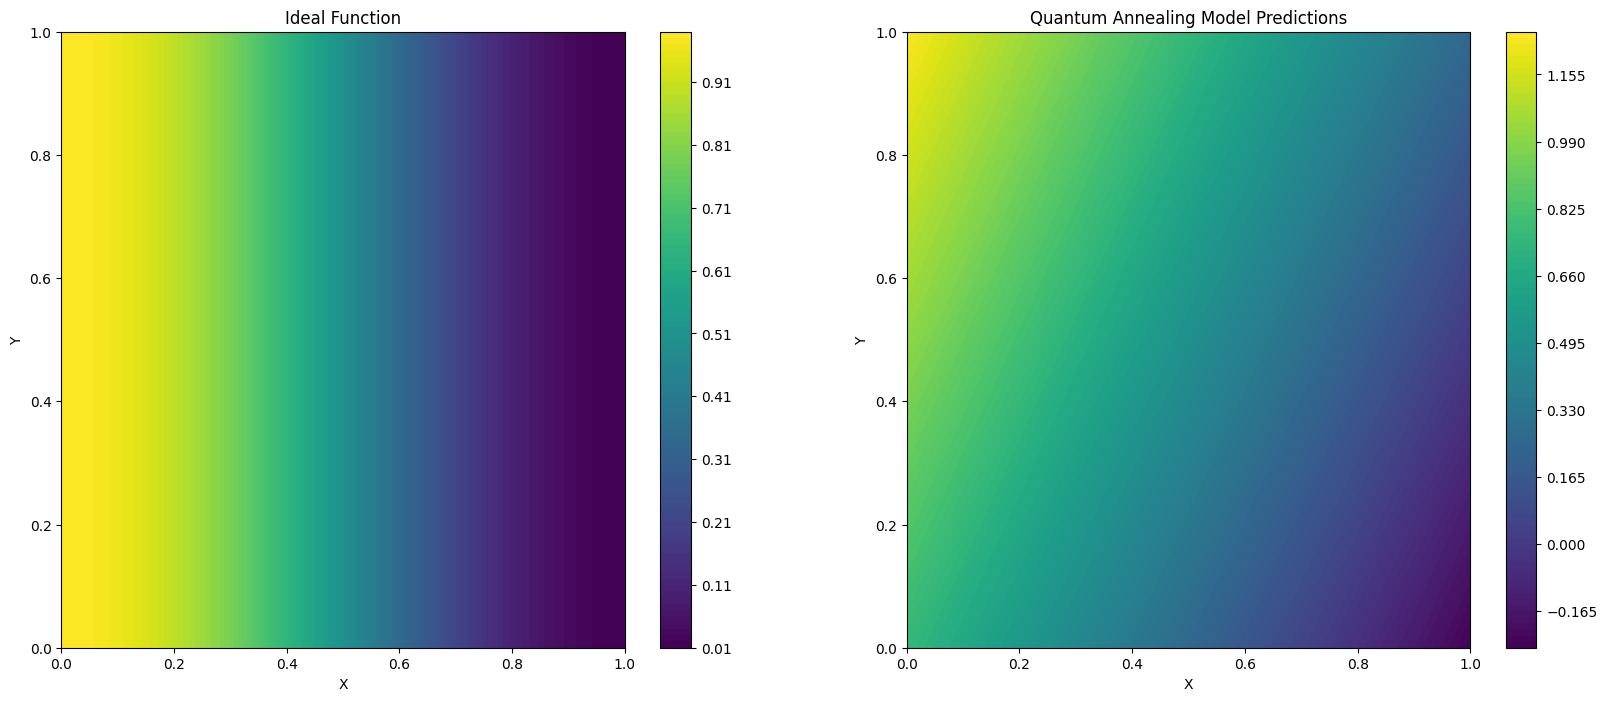

In [46]:
quantum_time_part2, quantum_time_part3, quantum_total_time_optimization, quantum_mse, quantum_r2 = run_annealing("QA", sampler, bqm, chain_strength * 0.5, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=2000)

Timing Information:
qpu_access_time: 183710 microseconds
charge_time: 2994652 microseconds
run_time: 2994652 microseconds
problem_id: 1a475f01-6e63-49bb-8f52-d3f4c7e36b2b microseconds

QPU Access Time: 183710 microseconds

Total D-Wave Run Time Including Setup: 2994652 microseconds
Time spent on hybrid part 2: 2.994652
Time spent on part 3: 0.00043218199971306603
Time spent on optimization: 3.118630817999159
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX2: Correct
AUX27: Correct
AUX36: Correct
AUX1: Correct
AUX7: Correct
AUX40: Correct
AUX3: Correct
AUX29: Correct
AUX41: 

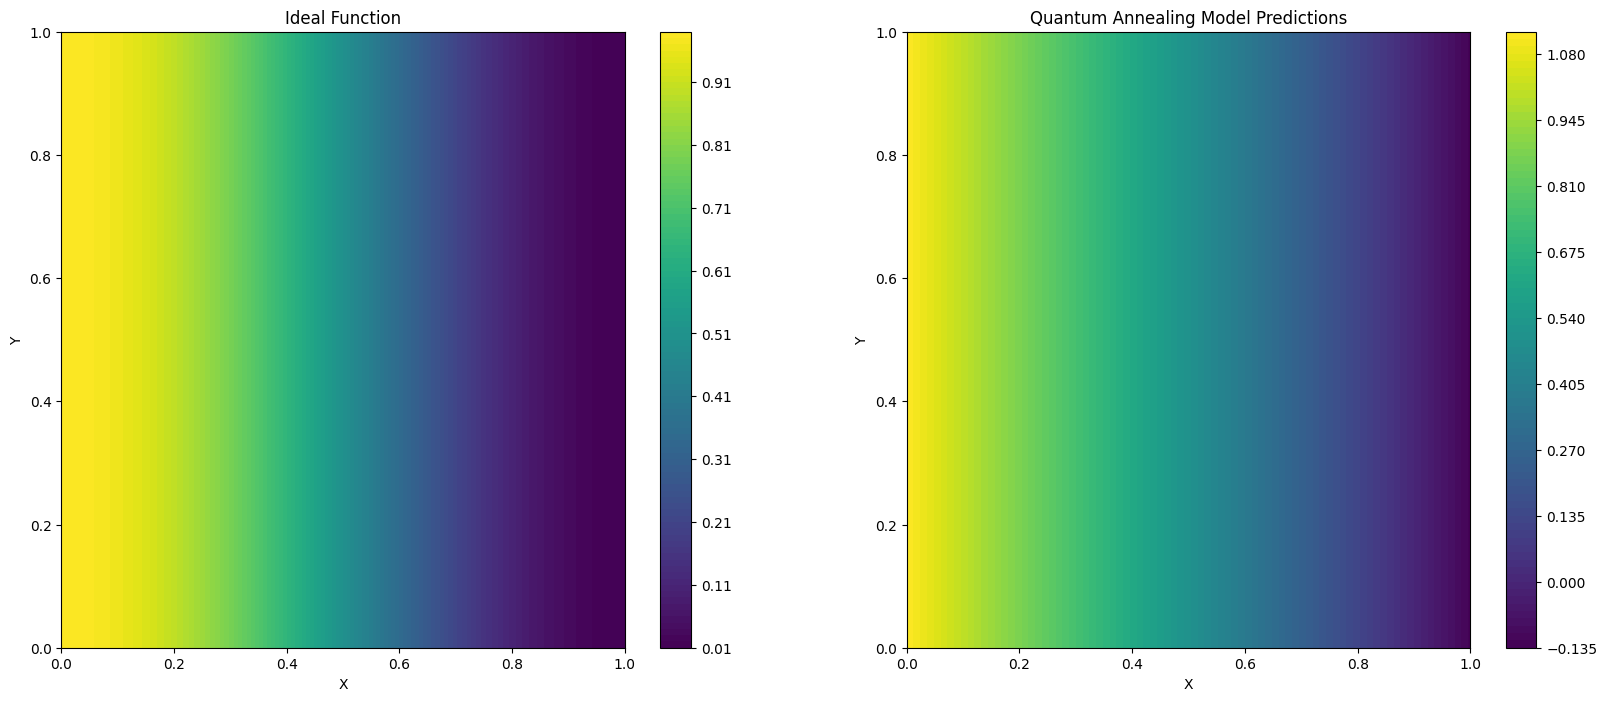

In [47]:
hybrid_time_part2, hybrid_time_part3, hybrid_total_time_optimization, hybrid_mse, hybrid_r2 = run_annealing("HQA", hybrid_sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=2000)

Time spent on simulated part 2: 10.105573818000266
Time spent on part 3: 0.0013924880004196893
Time spent on optimization: 10.230512942000132
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX2: Correct
AUX27: Correct
AUX36: Correct
AUX1: Correct
AUX7: Correct
AUX40: Correct
AUX3: Correct
AUX29: Correct
AUX41: Correct
AUX30: Correct
AUX34: Correct
AUX23: Correct
AUX4: Correct
AUX31: Correct
AUX32: Correct
AUX35: Correct
AUX13: Correct
Training time: 10.230512942000132, MSE: 0.0027, r2: 0.9784
time_part1: 0.12354663599944615, time_part2: 10.105573818000266, time_part3: 0.00139

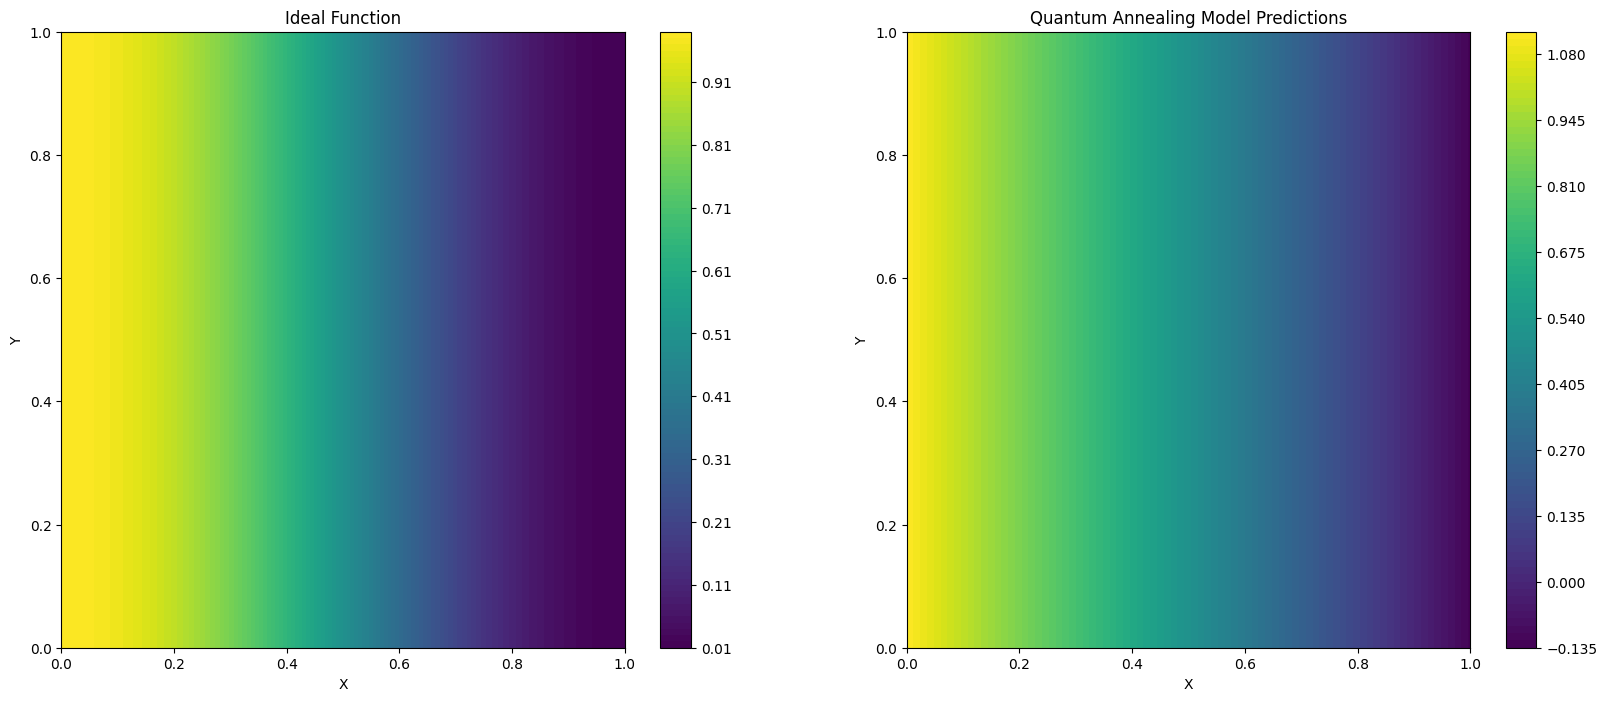

In [48]:
simulated_time_part2, simulated_time_part3, simulated_total_time_optimization, simulated_mse, simulated_r2 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=10000)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.53e-02 | test loss: nan | reg: 1.63e+00 : 100%|███████| 50/50 [00:36<00:00,  1.38it/s]


Training time in seconds of lr=0.05: 36.2532811150013
Learning Rate: 0.05, Train MSE: 0.0021474278019141184, Train r2: 0.9825900815313345


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.56e-02 | test loss: nan | reg: 1.29e+00 : 100%|███████| 50/50 [00:35<00:00,  1.40it/s]


Training time in seconds of lr=0.1: 35.80399632599983
Learning Rate: 0.1, Train MSE: 0.0024508103221276647, Train r2: 0.9801304575397721


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.39e-02 | test loss: nan | reg: 1.16e+00 : 100%|███████| 50/50 [00:36<00:00,  1.39it/s]


Training time in seconds of lr=0.2: 36.03306561499994
Learning Rate: 0.2, Train MSE: 0.0026086883764140476, Train r2: 0.978850487125555
Best Learning Rate: 0.05 with Train MSE: 0.0021474278019141184


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.53e-02 | test loss: nan | reg: 1.63e+00 : 100%|███████| 50/50 [00:36<00:00,  1.38it/s]


Training time in seconds: 36.122412290000284
Layer 0 Bezier coefficients:
[[-0.9536224   0.5619456 ]
 [ 0.09310207  0.09423756]]
Layer 1 Bezier coefficients:
[[ 0.37654546 -0.1582233 ]]


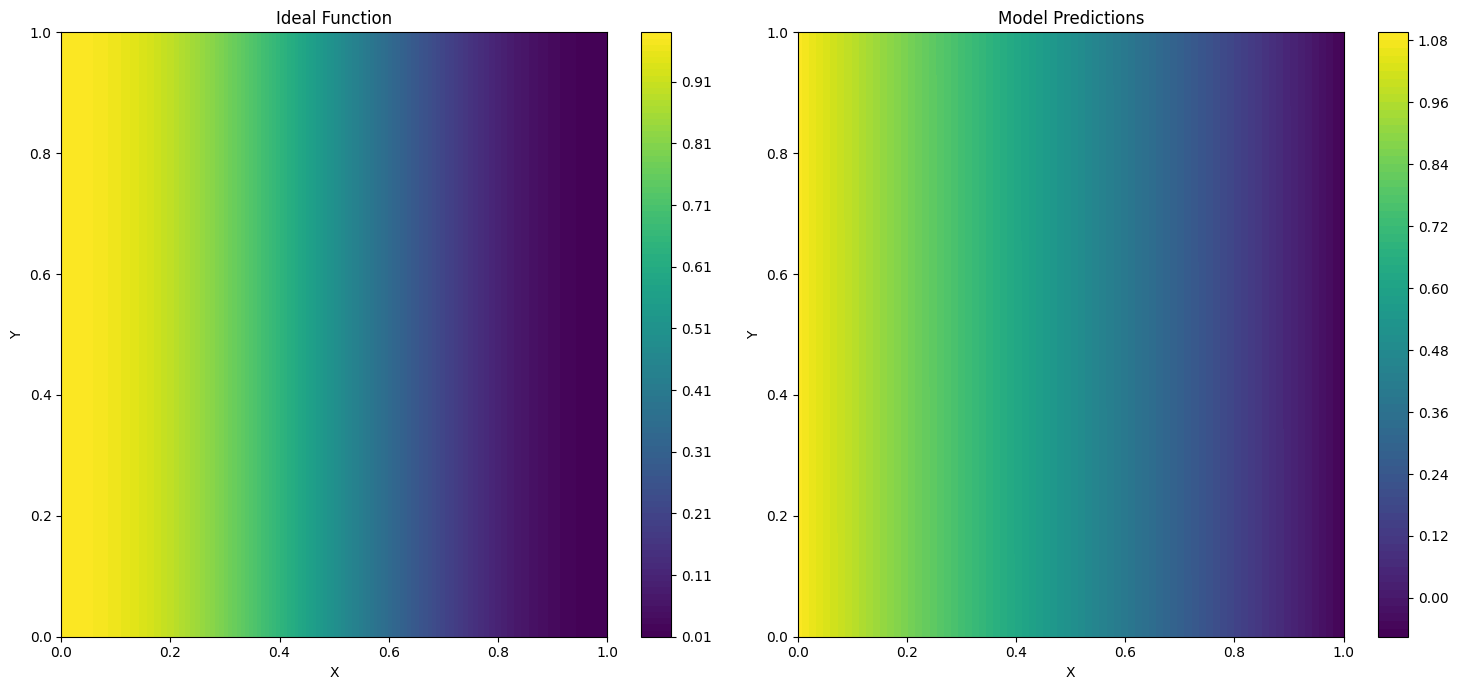

Training time: 36.122412290000284, mse: 0.0021511837974376715, r2: 0.9825596304140605


In [49]:
time_best_lr_adam, mse_adam, r2_adam = train_classical_optimizer(combined_dataset_4, degrees, "Adam", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 2.95e-01 | test loss: nan | reg: 3.25e+00 : 100%|███████| 50/50 [00:36<00:00,  1.37it/s]


Training time in seconds of lr=0.05: 36.40356068199981
Learning Rate: 0.05, Train MSE: 0.08115736972072879, Train r2: 0.3420299445179037


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 2.10e-01 | test loss: nan | reg: 1.27e+00 : 100%|███████| 50/50 [00:35<00:00,  1.40it/s]


Training time in seconds of lr=0.1: 35.61112459400101
Learning Rate: 0.1, Train MSE: 0.017266714017080572, Train r2: 0.8600129499156226


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.18e-02 | test loss: nan | reg: 2.06e+00 : 100%|███████| 50/50 [00:35<00:00,  1.42it/s]


Training time in seconds of lr=0.2: 35.32367923699894
Learning Rate: 0.2, Train MSE: 0.0020853168039543057, Train r2: 0.9830936362536511
Best Learning Rate: 0.2 with Train MSE: 0.0020853168039543057


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.18e-02 | test loss: nan | reg: 2.06e+00 : 100%|███████| 50/50 [00:35<00:00,  1.41it/s]


Training time in seconds: 35.50572236699918
Layer 0 Bezier coefficients:
[[-0.43060765  0.5575972 ]
 [ 0.06073374  0.05961598]]
Layer 1 Bezier coefficients:
[[ 0.5498491  -0.30388206]]


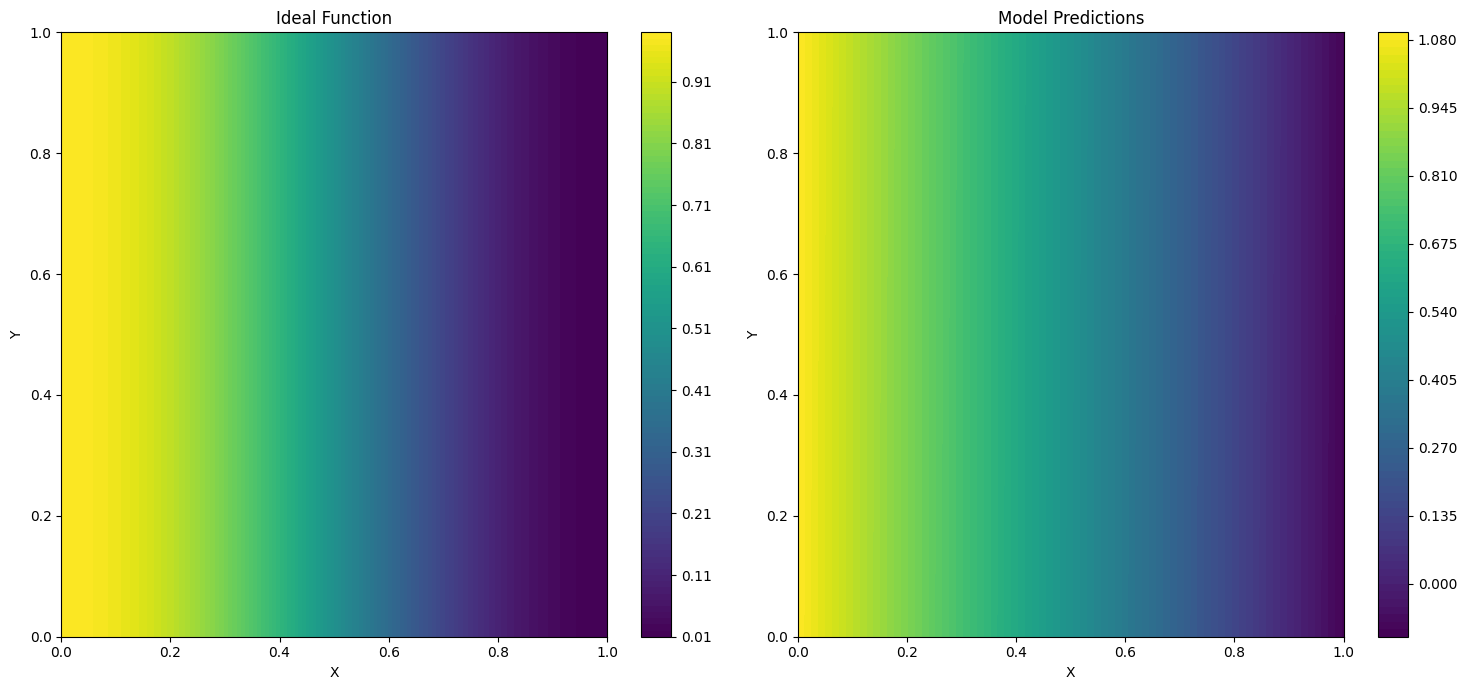

Training time: 35.50572236699918, mse: 0.002085394678581482, r2: 0.9830930048978921


In [50]:
time_best_lr_sgd, mse_sgd, r2_sgd = train_classical_optimizer(combined_dataset_4, degrees, "SGD", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.81e-02 | test loss: nan | reg: 2.02e+00 : 100%|███████| 50/50 [00:36<00:00,  1.38it/s]


Training time in seconds of lr=0.05: 36.31904279999981
Learning Rate: 0.05, Train MSE: 0.0021352371412650894, Train r2: 0.9826889153118181


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.15e-02 | test loss: nan | reg: 1.69e+00 : 100%|███████| 50/50 [00:36<00:00,  1.37it/s]


Training time in seconds of lr=0.1: 36.49675264399957
Learning Rate: 0.1, Train MSE: 0.002088198021144119, Train r2: 0.9830702772581494


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.15e-02 | test loss: nan | reg: 1.60e+00 : 100%|███████| 50/50 [00:36<00:00,  1.36it/s]


Training time in seconds of lr=0.2: 36.83121604400003
Learning Rate: 0.2, Train MSE: 0.002088964569028179, Train r2: 0.9830640625969851
Best Learning Rate: 0.1 with Train MSE: 0.002088198021144119


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.15e-02 | test loss: nan | reg: 1.69e+00 : 100%|███████| 50/50 [00:36<00:00,  1.38it/s]


Training time in seconds: 36.28665377199832
Layer 0 Bezier coefficients:
[[-0.6323296  0.3339918]
 [ 0.0542819  0.0542853]]
Layer 1 Bezier coefficients:
[[ 0.25903374 -0.23950997]]


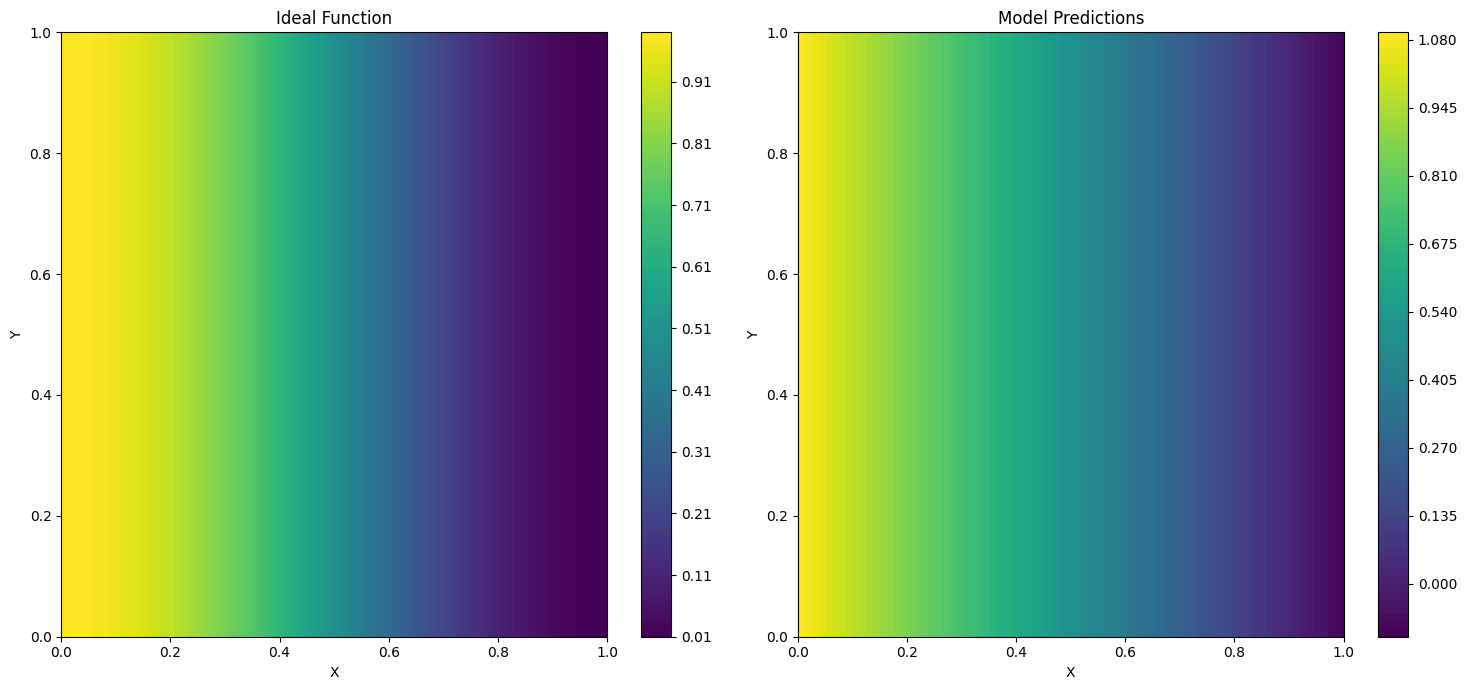

Training time: 36.28665377199832, mse: 0.002088338568185333, r2: 0.9830691377960793


In [51]:
time_best_lr_adagrad, mse_adagrad, r2_adagrad = train_classical_optimizer(combined_dataset_4, degrees, "AdaGrad", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

In [52]:
total_time_quantum.append(quantum_total_time_optimization)
total_time_hybrid.append(hybrid_total_time_optimization)
total_time_simulated.append(simulated_total_time_optimization)
total_time_adam.append(time_best_lr_adam)
total_time_sgd.append(time_best_lr_sgd)
total_time_adagrad.append(time_best_lr_adagrad)

print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {quantum_total_time_optimization}")
print(f"MSE: {quantum_mse:.4f}, r2: {quantum_r2:.4f}")

print("Hybrid Quantum Annealing Metrics:")
print(f"Total run time in seconds: {hybrid_total_time_optimization}")
print(f"MSE: {hybrid_mse:.4f}, r2: {hybrid_r2:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {simulated_total_time_optimization}")
print(f"MSE: {simulated_mse:.4f}, r2: {simulated_r2:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adam}")
print(f"MSE: {mse_adam:.4f}, r2: {r2_adam:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_sgd}")
print(f"MSE: {mse_sgd:.4f}, r2: {r2_sgd:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adagrad}")
print(f"MSE: {mse_adagrad:.4f}, r2: {r2_adagrad:.4f}")

# Total run times so far:
print(f"Array of time for quantum in each training/retraining: {total_time_quantum}, total time: {sum(total_time_quantum)}")
print(f"Array of time for hybrid in each training/retraining: {total_time_hybrid}, total time: {sum(total_time_hybrid)}")
print(f"Array of time for simulated in each training/retraining: {total_time_simulated}, total time: {sum(total_time_simulated)}")
print(f"Array of time for adam in each training/retraining: {total_time_adam}, total time: {sum(total_time_adam)}")
print(f"Array of time for SDG in each training/retraining: {total_time_sgd}, total time: {sum(total_time_sgd)}")
print(f"Array of time for adagrad in each training/retraining: {total_time_adagrad}, total time: {sum(total_time_adagrad)}")

Quantum Annealing Metrics:
Total run time in seconds: 0.3372056279985294
MSE: 0.0268, r2: 0.7827
Hybrid Quantum Annealing Metrics:
Total run time in seconds: 3.118630817999159
MSE: 0.0027, r2: 0.9784
Simulated Annealing Metrics
Total run time in seconds: 10.230512942000132
MSE: 0.0027, r2: 0.9784
Adam Optimizer Metrics
Total run time in seconds: 36.122412290000284
MSE: 0.0022, r2: 0.9826
SGD Optimizer Metrics
Total run time in seconds: 35.50572236699918
MSE: 0.0021, r2: 0.9831
AdaGrad Optimizer Metrics
Total run time in seconds: 36.28665377199832
MSE: 0.0021, r2: 0.9831
Array of time for quantum in each training/retraining: [0.8389014680008096, 0.3508777730002156, 0.37616825500078993, 0.3372056279985294], total time: 1.9031531240003443
Array of time for hybrid in each training/retraining: [3.494058329001469, 3.126897651999652, 3.1071980540023447, 3.118630817999159], total time: 12.846784853002625
Array of time for simulated in each training/retraining: [10.444197157000417, 10.327326627

# Adding a few more datapoints for dataset 5

In [53]:
dataset_4 = dataset
X_4 = X
y_4 = 1
x_data_4 = x_data
y_data_4 = y_data
z_data_4 = z_data

In [54]:
dataset = dataset_split4
X = dataset['train_input']
y = dataset['train_label']
x_data = X[:, 0].numpy()
y_data = X[:, 1].numpy()
z_data = y[:, 0].numpy()

In [55]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist(),
    load_filename=save_file4
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
# Mapping for P variables
for var in sorted(Solving_for_vars):
    var = str(var)
    if '_' in var:
        parts = var.split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]

# Mapping for AUX variables
aux_var_to_index = {var: idx for idx, var in enumerate(aux_dict_str.keys())}
for aux_var in aux_dict_str.keys():
    sympy_to_pyqubo_map[f"{aux_var}"] = coefficients_aux[aux_var_to_index[aux_var]]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm) #* 2.0

end_time_quantum_part1 = time.perf_counter()

In [56]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 0.1472825360015122


In [57]:
# Combine datasets
combined_train_input = torch.cat((dataset_4['train_input'], dataset_3['train_input'], dataset_2['train_input'], dataset_1['train_input'], dataset['train_input']), dim=0)
combined_train_label = torch.cat((dataset_3['train_label'], dataset_3['train_label'], dataset_2['train_label'], dataset_1['train_label'], dataset['train_label']), dim=0)
combined_test_input = torch.cat((dataset_4['test_input'], dataset_3['test_input'], dataset_2['test_input'], dataset_1['test_input'], dataset['test_input']), dim=0)
combined_test_label = torch.cat((dataset_4['test_label'], dataset_3['test_label'], dataset_2['test_label'], dataset_1['test_label'], dataset['test_label']), dim=0)
combined_dataset_5 = {
    'train_input': combined_train_input,
    'train_label': combined_train_label,
    'test_input': combined_test_input,
    'test_label': combined_test_label
}

Timing Information:
qpu_sampling_time: 171240.0 microseconds
qpu_anneal_time_per_sample: 20.0 microseconds
qpu_readout_time_per_sample: 45.05 microseconds
qpu_access_time: 190466.82 microseconds
qpu_access_overhead_time: 1489.18 microseconds
qpu_programming_time: 19226.82 microseconds
qpu_delay_time_per_sample: 20.57 microseconds
post_processing_overhead_time: 1.0 microseconds
total_post_processing_time: 1.0 microseconds

QPU Access Time: 190466.82 microseconds
Time spent on quantum annealer part 2: 0.19046682
Time spent on part 3: 0.0008711940008652164
Time spent on optimization: 0.33862055000237745
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 1.0]
optimized_coefficients_3: [1.75, 0.75]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
A

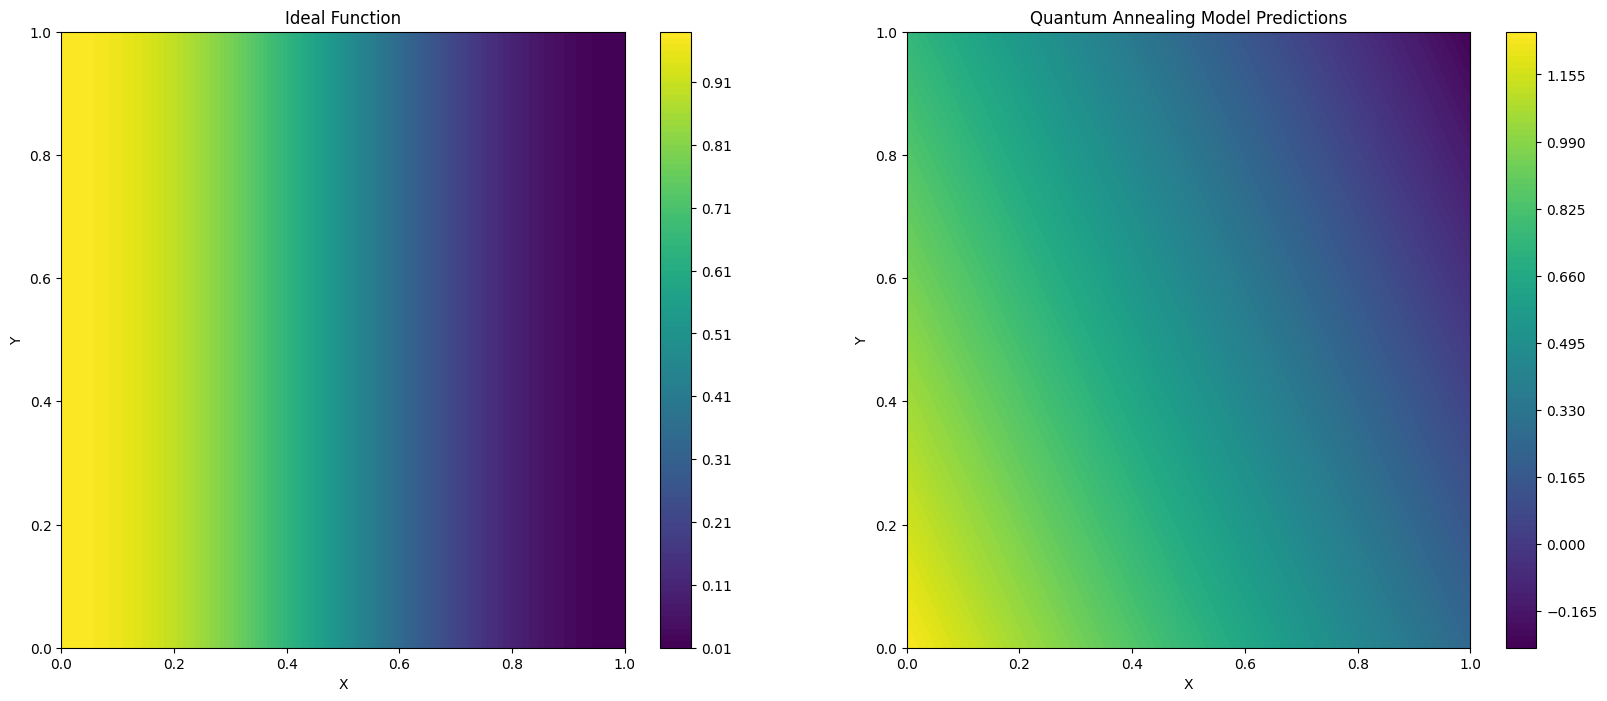

In [58]:
quantum_time_part2, quantum_time_part3, quantum_total_time_optimization, quantum_mse, quantum_r2 = run_annealing("QA", sampler, bqm, chain_strength * 0.5, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=2000)

Timing Information:
qpu_access_time: 106443 microseconds
charge_time: 2983029 microseconds
run_time: 2983029 microseconds
problem_id: f3f42114-f69b-40b2-8617-c52246a9b11b microseconds

QPU Access Time: 106443 microseconds

Total D-Wave Run Time Including Setup: 2983029 microseconds
Time spent on hybrid part 2: 2.9830289999999997
Time spent on part 3: 0.00041514700023981277
Time spent on optimization: 3.1307266830017517
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX2: Correct
AUX27: Correct
AUX36: Correct
AUX1: Correct
AUX7: Correct
AUX40: Correct
AUX3: Correct
AUX29: Corr

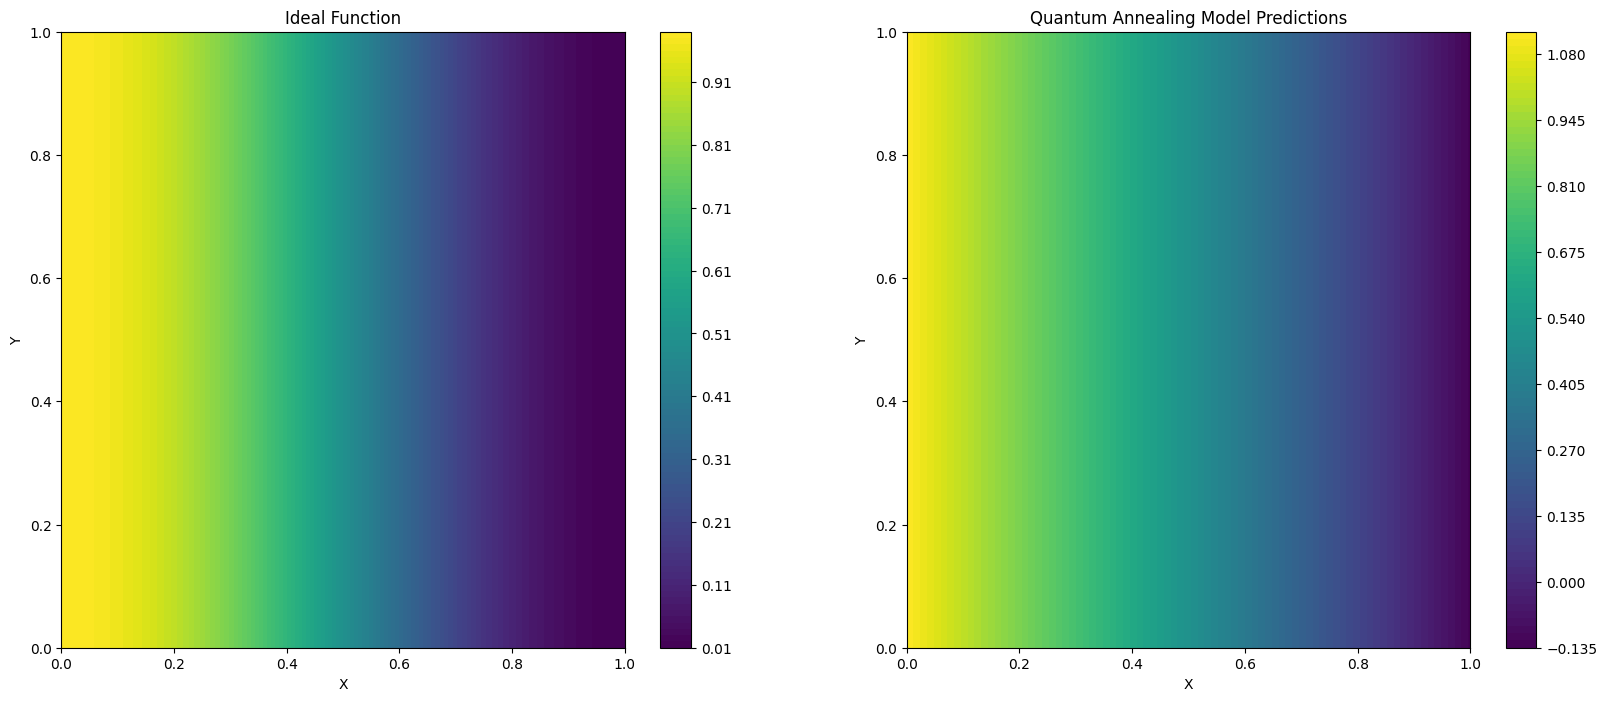

In [59]:
hybrid_time_part2, hybrid_time_part3, hybrid_total_time_optimization, hybrid_mse, hybrid_r2 = run_annealing("HQA", hybrid_sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=2000)

Time spent on simulated part 2: 10.098543101001269
Time spent on part 3: 0.0013711620013054926
Time spent on optimization: 10.247196799004087
optimized_coefficients_1: [0, 1]
optimized_coefficients_2: [0.5, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX0: Correct
AUX39: Correct
AUX28: Correct
AUX38: Correct
AUX12: Correct
AUX8: Correct
AUX37: Correct
AUX11: Correct
AUX26: Correct
AUX25: Correct
AUX17: Correct
AUX6: Correct
AUX14: Correct
AUX22: Correct
AUX15: Correct
AUX19: Correct
AUX10: Correct
AUX21: Correct
AUX16: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX2: Correct
AUX27: Correct
AUX36: Correct
AUX1: Correct
AUX7: Correct
AUX40: Correct
AUX3: Correct
AUX29: Correct
AUX41: Correct
AUX30: Correct
AUX34: Correct
AUX23: Correct
AUX4: Correct
AUX31: Correct
AUX32: Correct
AUX35: Correct
AUX13: Correct
Training time: 10.247196799004087, MSE: 0.0027, r2: 0.9784
time_part1: 0.1472825360015122, time_part2: 10.098543101001269, time_part3: 0.001371

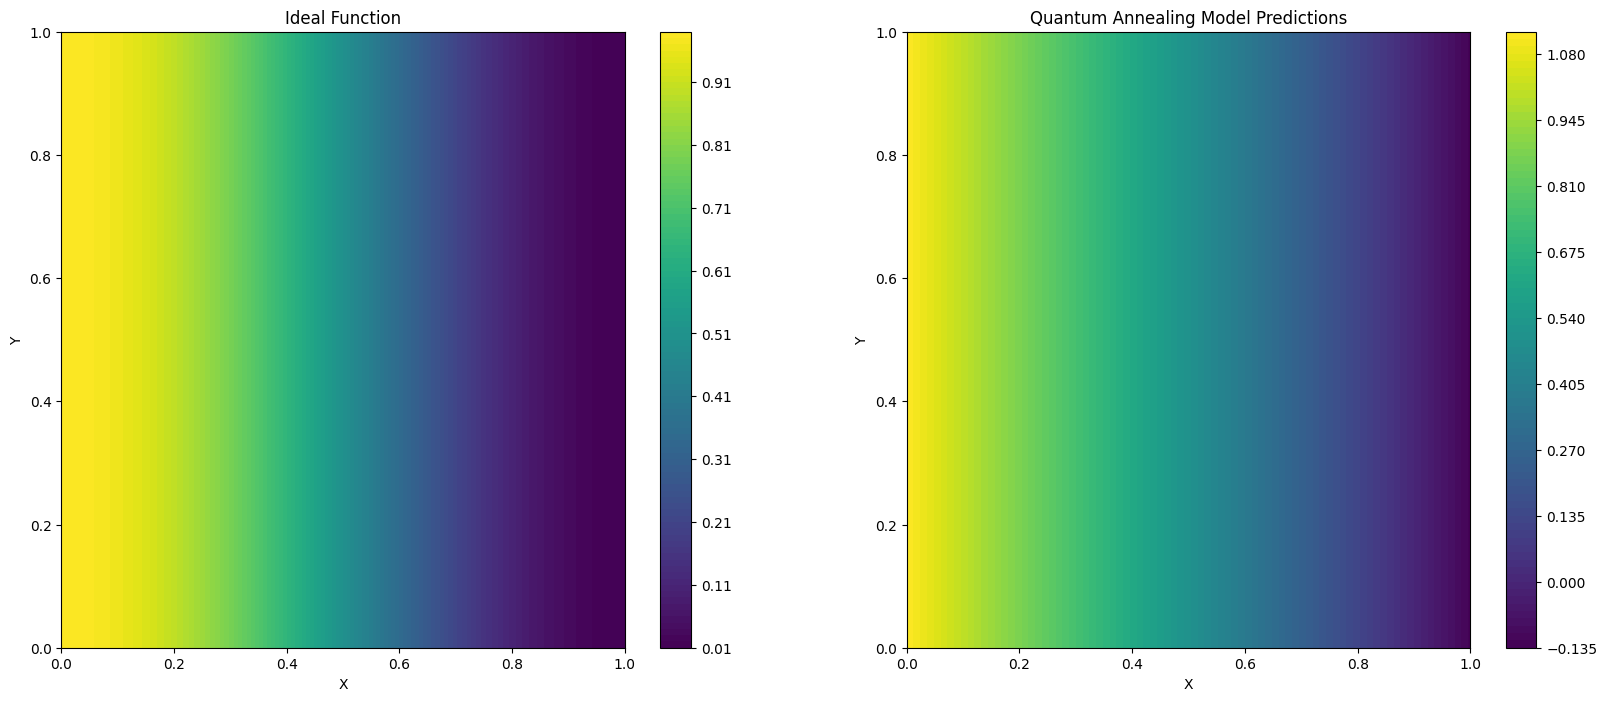

In [60]:
simulated_time_part2, simulated_time_part3, simulated_total_time_optimization, simulated_mse, simulated_r2 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=10000)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.42e-01 | test loss: nan | reg: 1.59e+00 : 100%|███████| 50/50 [00:38<00:00,  1.29it/s]


Training time in seconds of lr=0.05: 38.7291421810005
Learning Rate: 0.05, Train MSE: 0.0033715740741796364, Train r2: 0.9726655165355443


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.37e-01 | test loss: nan | reg: 1.36e+00 : 100%|███████| 50/50 [00:38<00:00,  1.30it/s]


Training time in seconds of lr=0.1: 38.593699320999804
Learning Rate: 0.1, Train MSE: 0.0026356154132788066, Train r2: 0.9786321805934329


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.39e-01 | test loss: nan | reg: 1.21e+00 : 100%|███████| 50/50 [00:38<00:00,  1.30it/s]


Training time in seconds of lr=0.2: 38.488713343998825
Learning Rate: 0.2, Train MSE: 0.0035589614363907437, Train r2: 0.9711463042503883
Best Learning Rate: 0.1 with Train MSE: 0.0026356154132788066


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.37e-01 | test loss: nan | reg: 1.36e+00 : 100%|███████| 50/50 [00:38<00:00,  1.30it/s]


Training time in seconds: 38.549081181001384
Layer 0 Bezier coefficients:
[[-0.9608187   0.8085382 ]
 [ 0.23253806  0.23550954]]
Layer 1 Bezier coefficients:
[[ 0.5150414  -0.03310587]]


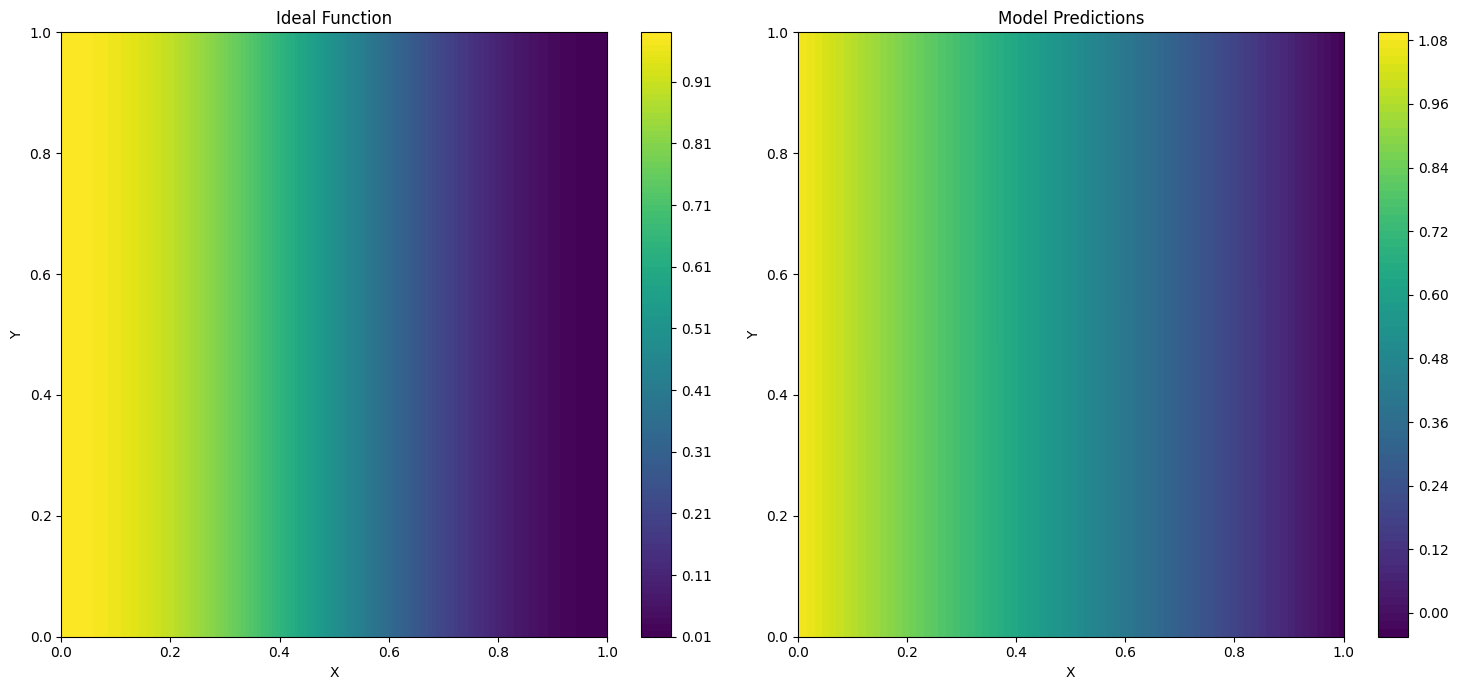

Training time: 38.549081181001384, mse: 0.0026452085577795504, r2: 0.9785544057488178


In [61]:
time_best_lr_adam, mse_adam, r2_adam = train_classical_optimizer(combined_dataset_5, degrees, "Adam", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 3.07e-01 | test loss: nan | reg: 3.45e+00 : 100%|███████| 50/50 [00:38<00:00,  1.29it/s]


Training time in seconds of lr=0.05: 38.80976542099961
Learning Rate: 0.05, Train MSE: 0.0849672885424118, Train r2: 0.3111416529541029


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 2.46e-01 | test loss: nan | reg: 1.10e+00 : 100%|███████| 50/50 [00:38<00:00,  1.31it/s]


Training time in seconds of lr=0.1: 38.08423038299952
Learning Rate: 0.1, Train MSE: 0.029918150243399905, Train r2: 0.7574435070615204


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.34e-01 | test loss: nan | reg: 2.02e+00 : 100%|███████| 50/50 [00:38<00:00,  1.31it/s]


Training time in seconds of lr=0.2: 38.30530441200062
Learning Rate: 0.2, Train MSE: 0.0024291696374978194, Train r2: 0.9803059058387444
Best Learning Rate: 0.2 with Train MSE: 0.0024291696374978194


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.34e-01 | test loss: nan | reg: 2.03e+00 : 100%|███████| 50/50 [00:37<00:00,  1.32it/s]


Training time in seconds: 37.890777507000166
Layer 0 Bezier coefficients:
[[-0.4196002   0.5345236 ]
 [ 0.05606576  0.05491458]]
Layer 1 Bezier coefficients:
[[ 0.5394949  -0.29573143]]


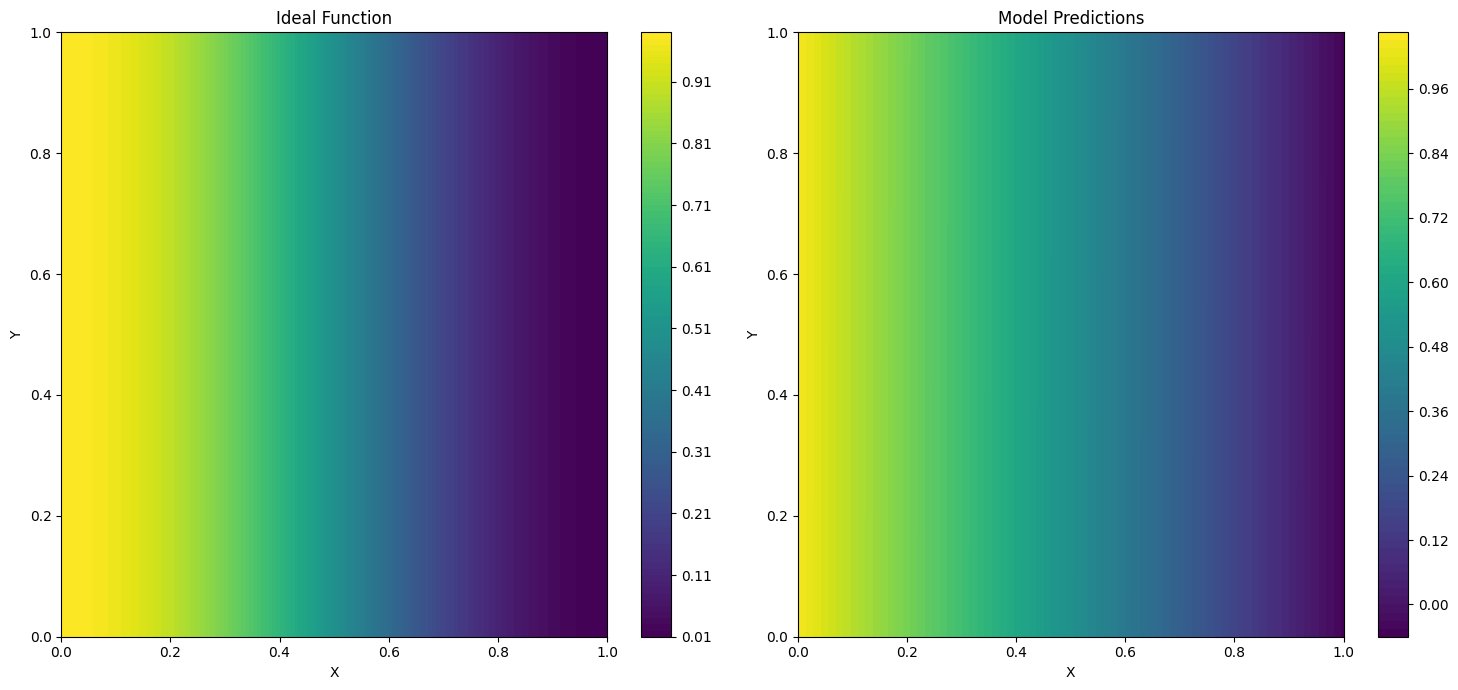

Training time: 37.890777507000166, mse: 0.002428570848113109, r2: 0.9803107604254078


In [62]:
time_best_lr_sgd, mse_sgd, r2_sgd = train_classical_optimizer(combined_dataset_5, degrees, "SGD", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.43e-01 | test loss: nan | reg: 2.22e+00 : 100%|███████| 50/50 [00:38<00:00,  1.31it/s]


Training time in seconds of lr=0.05: 38.034616970999195
Learning Rate: 0.05, Train MSE: 0.0031943205027511424, Train r2: 0.9741025707750858


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.34e-01 | test loss: nan | reg: 1.34e+00 : 100%|███████| 50/50 [00:38<00:00,  1.31it/s]


Training time in seconds of lr=0.1: 38.275289577000876
Learning Rate: 0.1, Train MSE: 0.002399603653244562, Train r2: 0.9805456072037152


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.34e-01 | test loss: nan | reg: 1.47e+00 : 100%|███████| 50/50 [00:37<00:00,  1.33it/s]


Training time in seconds of lr=0.2: 37.70434862300135
Learning Rate: 0.2, Train MSE: 0.0023918524240809772, Train r2: 0.980608449022029
Best Learning Rate: 0.2 with Train MSE: 0.0023918524240809772


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.34e-01 | test loss: nan | reg: 1.48e+00 : 100%|███████| 50/50 [00:37<00:00,  1.32it/s]


Training time in seconds: 37.99730772300063
Layer 0 Bezier coefficients:
[[-0.6990981   0.36168048]
 [ 0.04476647  0.0449684 ]]
Layer 1 Bezier coefficients:
[[ 0.2617798  -0.23070529]]


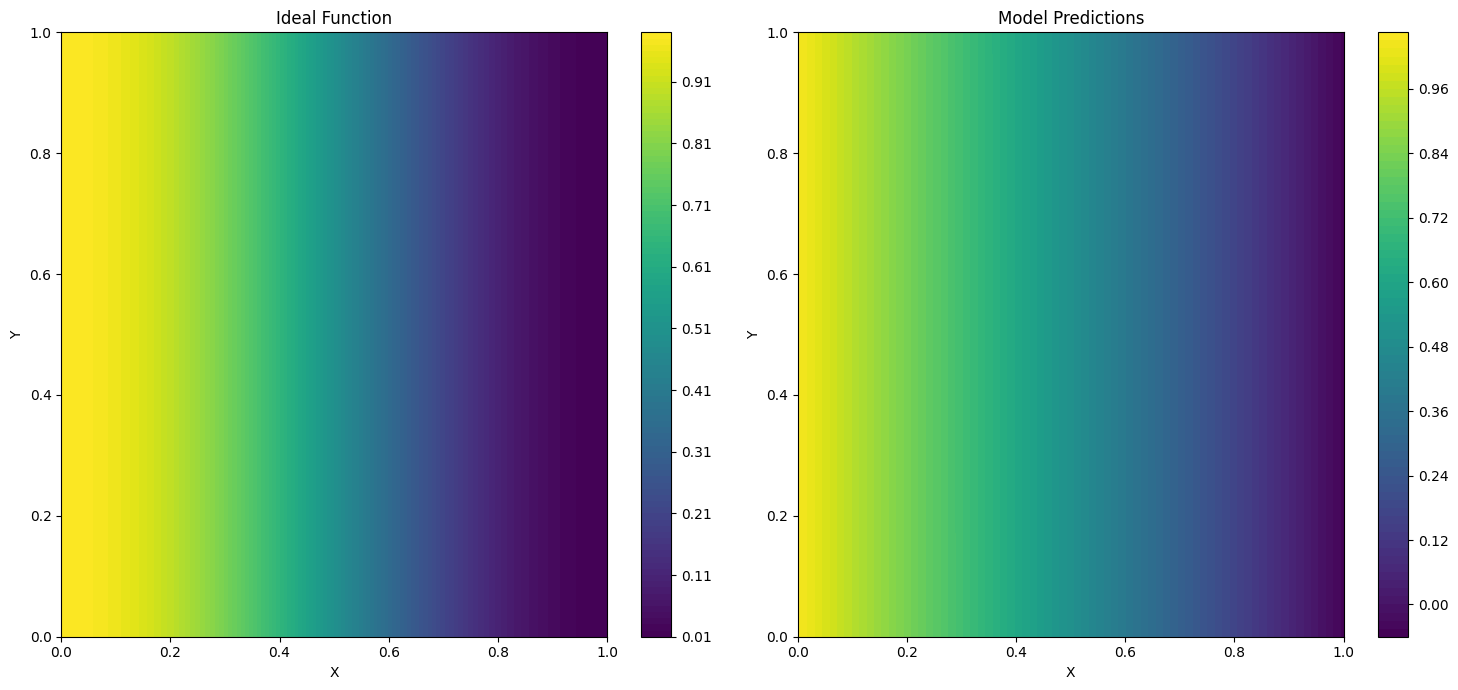

Training time: 37.99730772300063, mse: 0.002390001571253016, r2: 0.9806234545075703


In [63]:
time_best_lr_adagrad, mse_adagrad, r2_adagrad = train_classical_optimizer(combined_dataset_5, degrees, "AdaGrad", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

In [64]:
total_time_quantum.append(quantum_total_time_optimization)
total_time_hybrid.append(hybrid_total_time_optimization)
total_time_simulated.append(simulated_total_time_optimization)
total_time_adam.append(time_best_lr_adam)
total_time_sgd.append(time_best_lr_sgd)
total_time_adagrad.append(time_best_lr_adagrad)

print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {quantum_total_time_optimization}")
print(f"MSE: {quantum_mse:.4f}, r2: {quantum_r2:.4f}")

print("Hybrid Quantum Annealing Metrics:")
print(f"Total run time in seconds: {hybrid_total_time_optimization}")
print(f"MSE: {hybrid_mse:.4f}, r2: {hybrid_r2:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {simulated_total_time_optimization}")
print(f"MSE: {simulated_mse:.4f}, r2: {simulated_r2:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adam}")
print(f"MSE: {mse_adam:.4f}, r2: {r2_adam:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_sgd}")
print(f"MSE: {mse_sgd:.4f}, r2: {r2_sgd:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adagrad}")
print(f"MSE: {mse_adagrad:.4f}, r2: {r2_adagrad:.4f}")

# Total run times so far:
print(f"Array of time for quantum in each training/retraining: {total_time_quantum}, total time: {sum(total_time_quantum)}")
print(f"Array of time for hybrid in each training/retraining: {total_time_hybrid}, total time: {sum(total_time_hybrid)}")
print(f"Array of time for simulated in each training/retraining: {total_time_simulated}, total time: {sum(total_time_simulated)}")
print(f"Array of time for adam in each training/retraining: {total_time_adam}, total time: {sum(total_time_adam)}")
print(f"Array of time for SDG in each training/retraining: {total_time_sgd}, total time: {sum(total_time_sgd)}")
print(f"Array of time for adagrad in each training/retraining: {total_time_adagrad}, total time: {sum(total_time_adagrad)}")

Quantum Annealing Metrics:
Total run time in seconds: 0.33862055000237745
MSE: 0.0268, r2: 0.7827
Hybrid Quantum Annealing Metrics:
Total run time in seconds: 3.1307266830017517
MSE: 0.0027, r2: 0.9784
Simulated Annealing Metrics
Total run time in seconds: 10.247196799004087
MSE: 0.0027, r2: 0.9784
Adam Optimizer Metrics
Total run time in seconds: 38.549081181001384
MSE: 0.0026, r2: 0.9786
SGD Optimizer Metrics
Total run time in seconds: 37.890777507000166
MSE: 0.0024, r2: 0.9803
AdaGrad Optimizer Metrics
Total run time in seconds: 37.99730772300063
MSE: 0.0024, r2: 0.9806
Array of time for quantum in each training/retraining: [0.8389014680008096, 0.3508777730002156, 0.37616825500078993, 0.3372056279985294, 0.33862055000237745], total time: 2.241773674002722
Array of time for hybrid in each training/retraining: [3.494058329001469, 3.126897651999652, 3.1071980540023447, 3.118630817999159, 3.1307266830017517], total time: 15.977511536004377
Array of time for simulated in each training/re

# Save the datasets

In [65]:
import pickle

# Save the entire dataset as a pickle file
dataset_file = f'dataset_2_1_sph_harm_retraining_hybrid_dataset1.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset_1, f)

print(f"Dataset 1 saved to {dataset_file}")

# Save the entire dataset as a pickle file
dataset_file = f'dataset_2_1_sph_harm_retraining_hybrid_dataset2.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset_1, f)

print(f"Dataset 2 saved to {dataset_file}")

# Save the entire dataset as a pickle file
dataset_file = f'dataset_2_1_sph_harm_retraining_hybrid_dataset3.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset_1, f)

print(f"Dataset 3 saved to {dataset_file}")

# Save the entire dataset as a pickle file
dataset_file = f'dataset_2_1_sph_harm_retraining_hybrid_dataset4.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset_1, f)

print(f"Dataset 4 saved to {dataset_file}")

# Save the entire dataset as a pickle file
dataset_file = f'dataset_2_1_sph_harm_retraining_hybrid_dataset5.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset_1, f)

print(f"Dataset 5 saved to {dataset_file}")

Dataset 1 saved to dataset_2_1_sph_harm_retraining_hybrid_dataset1.pkl
Dataset 2 saved to dataset_2_1_sph_harm_retraining_hybrid_dataset2.pkl
Dataset 3 saved to dataset_2_1_sph_harm_retraining_hybrid_dataset3.pkl
Dataset 4 saved to dataset_2_1_sph_harm_retraining_hybrid_dataset4.pkl
Dataset 5 saved to dataset_2_1_sph_harm_retraining_hybrid_dataset5.pkl
